# **Telecom X: Previsão de Churn com Machine Learning**  

## **Visão Geral do Projeto**  
Este desafio foca na **construção de modelos preditivos** para antecipar a evasão de clientes (*churn*) em uma operadora de telecomunicações. Utilizando dados pré-processados (ETL - Parte 1), o projeto abrange desde análise exploratória até a implantação de algoritmos de classificação, com o objetivo de:  
- **Identificar padrões** críticos nos dados.  
- **Prever riscos de churn** com métricas mensuráveis.  
- **Gerar insights acionáveis** para a equipe de retenção.  

---

## **Destaques do Fluxo de Trabalho**  
### 🔎 **Análise Exploratória (EDA)**  
- Correlações entre variáveis (ex: tempo de contrato vs. churn).  
- Visualização de perfis de clientes (fiéis vs. evadidos).  

### ⚙️ **Pré-processamento**  
- Codificação de variáveis categóricas (*One-Hot Encoding*).  
- Normalização de dados numéricos.  
- Divisão estratificada (treino/teste).  

### 🤖 **Modelagem Preditiva**  
- **Algoritmos testados**:  
  - *Baseline*: Regressão Logística.  
  - *Comparação*: Random Forest e XGBoost.  
- **Métricas de avaliação**:  
  - Precisão, Recall, AUC-ROC, Matriz de Confusão.  

### 📈 **Resultados e Ações**  
- Importância das features (SHAP/Feature Importance).  
- Recomendações baseadas em dados (ex: "Clientes com contrato mensal têm 3x mais churn").  

---

## **Estrutura do Repositório**  
```
TELECOM-X2/
├── data/
│   ├── raw/                    # Dados originais
│   └── processed/              # Dados tratados (CSV/Parquet)
├── notebooks/
│   ├── EDA.ipynb               # Análise exploratória
│   └── Modelagem.ipynb         # Treino e avaliação
├── visualizations/             # Gráficos exportados
├── .gitignore                  # Configuração do Git
├── README.md                   # Documentação
└── task.md                     # Requisitos do desafio
```

---

## **Ferramentas e Tecnologias**  
- **Linguagem**: Python.  
- **Bibliotecas**: Pandas, Scikit-Learn, XGBoost, Matplotlib/Seaborn.  
- **Versionamento**: Git/GitHub.  
- **Ambiente**: Jupyter Notebook ou Google Colab.  

---

## **Próximos Passos**  
1. **Carregar dados** e validar qualidade.  
2. **Explorar correlações** com heatmaps e histogramas.  
3. **Treinar modelos** e comparar performance.  
4. **Documentar insights** no README.  

**Objetivo Final**: Entregar um pipeline reprodutível para prever churn, com impacto mensurável na redução de evasão.  

# Telecom X: Preparação dos Dados para Modelagem de Churn

Preparação dos dados para o modelo de previsão de churn. Vamos seguir as etapas solicitadas:

## 1. Carregamento e Inspeção Inicial dos Dados


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# Carregar os dados
df = pd.read_csv('dados.csv')

# Visualizar as primeiras linhas
print(df.head())
print("\nInformações do DataFrame:")
print(df.info())

   customerID Churn                                           customer  \
0  0002-ORFBO    No  {'gender': 'Female', 'SeniorCitizen': 0, 'Part...   
1  0003-MKNFE    No  {'gender': 'Male', 'SeniorCitizen': 0, 'Partne...   
2  0004-TLHLJ   Yes  {'gender': 'Male', 'SeniorCitizen': 0, 'Partne...   
3  0011-IGKFF   Yes  {'gender': 'Male', 'SeniorCitizen': 1, 'Partne...   
4  0013-EXCHZ   Yes  {'gender': 'Female', 'SeniorCitizen': 1, 'Part...   

                                             phone  \
0   {'PhoneService': 'Yes', 'MultipleLines': 'No'}   
1  {'PhoneService': 'Yes', 'MultipleLines': 'Yes'}   
2   {'PhoneService': 'Yes', 'MultipleLines': 'No'}   
3   {'PhoneService': 'Yes', 'MultipleLines': 'No'}   
4   {'PhoneService': 'Yes', 'MultipleLines': 'No'}   

                                            internet  \
0  {'InternetService': 'DSL', 'OnlineSecurity': '...   
1  {'InternetService': 'DSL', 'OnlineSecurity': '...   
2  {'InternetService': 'Fiber optic', 'OnlineSecu...   
3  {'I

## 2. Remoção de Colunas Irrelevantes e Tratamento de Valores Ausentes

In [3]:
# Remover colunas de identificação que não são úteis para o modelo
colunas_remover = ['customerID']
df = df.drop(columns=colunas_remover, errors='ignore')

# Remover linhas onde 'Churn' é nulo (antes de qualquer análise/modelagem)
df = df.dropna(subset=['Churn'])

# Verificar colunas restantes e tamanho do DataFrame após limpeza
print("\nColunas após remoção:")
print(df.columns)
print(f"\nTotal de registros após remoção: {len(df)}")


Colunas após remoção:
Index(['Churn', 'customer', 'phone', 'internet', 'account'], dtype='object')

Total de registros após remoção: 7043


## 3. Extração e Expansão de Dados Aninhados

In [4]:
import ast

# Função melhorada para extrair dados aninhados com tratamento de erros
def expand_dict_columns(df, column_name):
    try:
        # Converter strings para dicionários
        expanded = df[column_name].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else {})

        # Normalizar os dados aninhados
        expanded_df = pd.json_normalize(expanded)

        # Renomear colunas para incluir o nome original
        expanded_df.columns = [f"{column_name}_{col}" for col in expanded_df.columns]

        # Verificar se a expansão criou colunas
        if expanded_df.empty:
            print(f"Aviso: A coluna {column_name} não foi expandida (nenhum dado aninhado encontrado)")
            return pd.DataFrame()

        return expanded_df

    except Exception as e:
        print(f"Erro ao processar a coluna {column_name}: {str(e)}")
        return pd.DataFrame()

# Lista de colunas aninhadas para expandir
nested_columns = ['customer', 'phone', 'internet', 'account']

# Expandir cada coluna aninhada e armazenar os resultados
expanded_dfs = {}
for col in nested_columns:
    expanded_dfs[col] = expand_dict_columns(df, col)
    print(f"\nColunas criadas a partir de {col}:")
    print(expanded_dfs[col].columns.tolist())

# Concatenar todas as expansões com o DataFrame original
df_expanded = pd.concat([
    df.drop(columns=nested_columns),
    *expanded_dfs.values()
], axis=1)

# Verificar o novo formato
print("\nResumo do DataFrame após expansão:")
print(f"Número de colunas original: {len(df.columns)}")
print(f"Número de colunas após expansão: {len(df_expanded.columns)}")
print("\nPrimeiras linhas após expansão:")
print(df_expanded.head(2).T)  # Transposto para melhor visualização


Colunas criadas a partir de customer:
['customer_gender', 'customer_SeniorCitizen', 'customer_Partner', 'customer_Dependents', 'customer_tenure']

Colunas criadas a partir de phone:
['phone_PhoneService', 'phone_MultipleLines']

Colunas criadas a partir de internet:
['internet_InternetService', 'internet_OnlineSecurity', 'internet_OnlineBackup', 'internet_DeviceProtection', 'internet_TechSupport', 'internet_StreamingTV', 'internet_StreamingMovies']

Colunas criadas a partir de account:
['account_Contract', 'account_PaperlessBilling', 'account_PaymentMethod', 'account_Charges.Monthly', 'account_Charges.Total']

Resumo do DataFrame após expansão:
Número de colunas original: 5
Número de colunas após expansão: 20

Primeiras linhas após expansão:
                                      0               1
Churn                                No              No
customer_gender                  Female            Male
customer_SeniorCitizen              0.0             0.0
customer_Partner       

## 4. Encoding de Variáveis Categóricas

In [5]:
# Identificar colunas categóricas e numéricas de forma mais precisa
categorical_cols = df_expanded.select_dtypes(include=['object', 'bool']).columns.tolist()
numerical_cols = df_expanded.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Verificar e tratar a variável target
target_col = 'Churn'
if target_col in categorical_cols:
    categorical_cols.remove(target_col)
    # Converter target para binário (0/1)
    df_expanded[target_col] = df_expanded[target_col].map({'Yes': 1, 'No': 0})

# Tratar a coluna account_Charges.Total que parece categórica (foi identificada como objeto)
if 'account_Charges.Total' in categorical_cols:
    try:
        df_expanded['account_Charges.Total'] = pd.to_numeric(df_expanded['account_Charges.Total'])
        numerical_cols.append('account_Charges.Total')
        categorical_cols.remove('account_Charges.Total')
    except Exception as e:
        print(f"Erro ao converter account_Charges.Total: {str(e)}")

print("\nColunas categóricas para encoding:", categorical_cols)
print("Colunas numéricas:", numerical_cols)
print("\nDistribuição das categorias:")
for col in categorical_cols:
    print(f"\n{col}:")
    print(df_expanded[col].value_counts())

# Aplicar One-Hot Encoding com tratamento para categorias raras
encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
encoded_data = encoder.fit_transform(df_expanded[categorical_cols])
encoded_cols = encoder.get_feature_names_out(categorical_cols)

# Criar DataFrame com variáveis codificadas
df_encoded = pd.DataFrame(encoded_data, columns=encoded_cols, index=df_expanded.index)

# Concatenar com as numéricas e a target
df_final = pd.concat([
    df_expanded[numerical_cols],
    df_encoded,
    df_expanded[target_col]
], axis=1)

# Verificar resultado
print("\nResumo do DataFrame após encoding:")
print(f"Total de colunas: {len(df_final.columns)}")
print("\nPrimeiras linhas:")
print(df_final.iloc[:, -10:].head())  # Mostrar as últimas 10 colunas para visualizar o encoding

Erro ao converter account_Charges.Total: Unable to parse string " " at position 916

Colunas categóricas para encoding: ['customer_gender', 'customer_Partner', 'customer_Dependents', 'phone_PhoneService', 'phone_MultipleLines', 'internet_InternetService', 'internet_OnlineSecurity', 'internet_OnlineBackup', 'internet_DeviceProtection', 'internet_TechSupport', 'internet_StreamingTV', 'internet_StreamingMovies', 'account_Contract', 'account_PaperlessBilling', 'account_PaymentMethod', 'account_Charges.Total']
Colunas numéricas: ['customer_SeniorCitizen', 'customer_tenure', 'account_Charges.Monthly']

Distribuição das categorias:

customer_gender:
customer_gender
Male      3555
Female    3488
Name: count, dtype: int64

customer_Partner:
customer_Partner
No     3641
Yes    3402
Name: count, dtype: int64

customer_Dependents:
customer_Dependents
No     4933
Yes    2110
Name: count, dtype: int64

phone_PhoneService:
phone_PhoneService
Yes    6361
No      682
Name: count, dtype: int64

phone_Mu

### 1. Tratar os valores vazios em account_Charges.Total


In [6]:
# Verificar valores problemáticos
print("Valores únicos problemáticos:", df_expanded[df_expanded['account_Charges.Total'].str.strip() == ""]['account_Charges.Total'].unique())

# Substituir valores vazios por NaN e converter para numérico
df_expanded['account_Charges.Total'] = pd.to_numeric(df_expanded['account_Charges.Total'].replace(r'^\s*$', np.nan, regex=True), errors='coerce')

# Preencher NaN (opcional - pode ser com média, mediana ou outro método)
df_expanded['account_Charges.Total'] = df_expanded['account_Charges.Total'].fillna(df_expanded['account_Charges.Total'].median())

Valores únicos problemáticos: [' ']


### 2. Corrigir a identificação de colunas categóricas

In [7]:
# Identificar corretamente as colunas
categorical_cols = [
    'customer_gender', 'customer_Partner', 'customer_Dependents',
    'phone_PhoneService', 'phone_MultipleLines', 'internet_InternetService',
    'internet_OnlineSecurity', 'internet_OnlineBackup', 'internet_DeviceProtection',
    'internet_TechSupport', 'internet_StreamingTV', 'internet_StreamingMovies',
    'account_Contract', 'account_PaperlessBilling', 'account_PaymentMethod'
]

numerical_cols = [
    'customer_SeniorCitizen', 'customer_tenure',
    'account_Charges.Monthly', 'account_Charges.Total'
]

### 3. Aplicar One-Hot Encoding apenas nas colunas categóricas corretas

In [8]:
# One-Hot Encoding apenas para colunas categóricas verdadeiras
encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
encoded_data = encoder.fit_transform(df_expanded[categorical_cols])
encoded_cols = encoder.get_feature_names_out(categorical_cols)

# Criar DataFrame codificado
df_encoded = pd.DataFrame(encoded_data, columns=encoded_cols, index=df_expanded.index)

# Concatenar corretamente
df_final = pd.concat([
    df_expanded[numerical_cols],
    df_encoded,
    df_expanded['Churn']
], axis=1)

print("\nDimensões finais:", df_final.shape)
print("Colunas numéricas:", numerical_cols)
print("Colunas categóricas codificadas:", len(encoded_cols))


Dimensões finais: (7256, 46)
Colunas numéricas: ['customer_SeniorCitizen', 'customer_tenure', 'account_Charges.Monthly', 'account_Charges.Total']
Colunas categóricas codificadas: 41


### 4. Verificação final


In [9]:
print("\nAmostra dos dados finais:")
print(df_final.iloc[:, -15:].head())  # Mostrar algumas colunas codificadas


Amostra dos dados finais:
   internet_StreamingTV_Yes  internet_StreamingTV_nan  \
0                       1.0                       0.0   
1                       0.0                       0.0   
2                       0.0                       0.0   
3                       1.0                       0.0   
4                       1.0                       0.0   

   internet_StreamingMovies_No internet service  internet_StreamingMovies_Yes  \
0                                           0.0                           0.0   
1                                           0.0                           1.0   
2                                           0.0                           0.0   
3                                           0.0                           1.0   
4                                           0.0                           0.0   

   internet_StreamingMovies_nan  account_Contract_One year  \
0                           0.0                        1.0   
1                  

## 5. Verificação da Proporção de Evasão (Versão Aprimorada)


=== ANÁLISE DE BALANCEAMENTO ===

Distribuição absoluta:
Churn
0.0    5174
1.0    1869
Name: count, dtype: int64

Distribuição percentual:
Churn
0.0    73.46
1.0    26.54
Name: proportion, dtype: float64

Razão de desbalanceamento: 2.77:1
Total de amostras: 7256


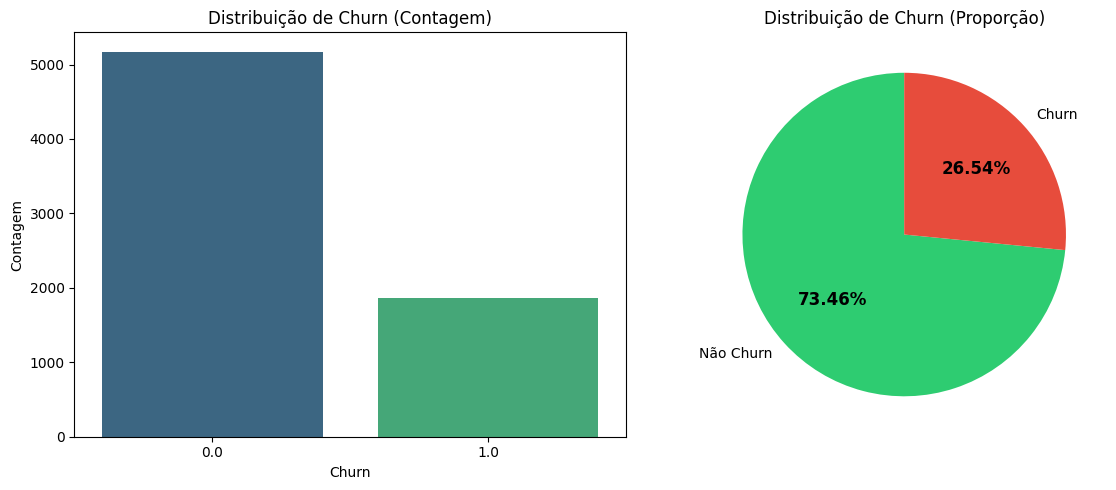


Distribuição de Churn por SeniorCitizen:
Churn                    0.0   1.0
customer_SeniorCitizen            
0.0                     0.73  0.27
1.0                     0.74  0.26


In [12]:
# Adicione estas linhas no início do notebook (célula de importações)
import matplotlib.pyplot as plt
import seaborn as sns

# Verificação detalhada do balanceamento
print("\n=== ANÁLISE DE BALANCEAMENTO ===")

# Estatísticas básicas
churn_counts = df_final['Churn'].value_counts()
churn_percentage = df_final['Churn'].value_counts(normalize=True) * 100

# Adicionando métricas de desbalanceamento
total_samples = len(df_final)
imbalance_ratio = churn_counts[0] / churn_counts[1]  # Razão entre maioria/minoria

print("\nDistribuição absoluta:")
print(churn_counts)
print("\nDistribuição percentual:")
print(churn_percentage.round(2))
print(f"\nRazão de desbalanceamento: {imbalance_ratio:.2f}:1")
print(f"Total de amostras: {total_samples}")

# Visualização aprimorada
plt.figure(figsize=(12, 5))

# Gráfico 1: Contagem simples
plt.subplot(1, 2, 1)
sns.countplot(x='Churn', hue='Churn', data=df_final, palette='viridis', legend=False)
plt.title('Distribuição de Churn (Contagem)')
plt.xlabel('Churn')
plt.ylabel('Contagem')

# Gráfico 2: Proporção com anotações
plt.subplot(1, 2, 2)
patches, texts, autotexts = plt.pie(
    churn_percentage,
    labels=['Não Churn', 'Churn'],
    autopct='%.2f%%',
    colors=['#2ecc71', '#e74c3c'],
    startangle=90
)
plt.title('Distribuição de Churn (Proporção)')
plt.setp(autotexts, size=12, weight="bold")

plt.tight_layout()
plt.show()

# Análise adicional por grupos importantes (opcional)
if 'customer_SeniorCitizen' in df_final.columns:
    print("\nDistribuição de Churn por SeniorCitizen:")
    print(pd.crosstab(df_final['customer_SeniorCitizen'], df_final['Churn'], normalize='index').round(2))

## 6. Balanceamento de Classes (opcional)

## 7. Normalização/Padronização (se necessário)

In [18]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

# 1. Remoção COMPLETA de linhas com qualquer NaN
print("Tamanho original do DataFrame:", len(df_final))
df_final_clean = df_final.dropna(how='any')  # Remove qualquer linha com NaN
print("Tamanho após remoção de NaN:", len(df_final_clean))

# 2. Verificação final
print("\nValores nulos após limpeza:")
print(df_final_clean.isnull().sum())

# 3. Separar features e target
X = df_final_clean.drop('Churn', axis=1)
y = df_final_clean['Churn']

# 4. Verificar balanceamento
print("\nDistribuição do target:")
print(y.value_counts(normalize=True))

# 5. Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# 6. Aplicar SMOTE
try:
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
    print("\nShape após SMOTE - X:", X_resampled.shape, "y:", y_resampled.shape)
    print("Distribuição após SMOTE:\n", pd.Series(y_resampled).value_counts())
except Exception as e:
    print("\nErro no SMOTE:", str(e))
    raise

# 7. Identificar colunas numéricas para padronização
numeric_cols = ['customer_tenure', 'account_Charges.Monthly', 'account_Charges.Total']

# 8. Padronização
scaler = StandardScaler()
X_resampled[numeric_cols] = scaler.fit_transform(X_resampled[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

print("\nProcesso concluído com sucesso!")
print("Amostra dos dados padronizados:")
print(X_resampled[numeric_cols].head())

Tamanho original do DataFrame: 7256
Tamanho após remoção de NaN: 6830

Valores nulos após limpeza:
customer_SeniorCitizen                           0
customer_tenure                                  0
account_Charges.Monthly                          0
account_Charges.Total                            0
customer_gender_Male                             0
customer_gender_nan                              0
customer_Partner_Yes                             0
customer_Partner_nan                             0
customer_Dependents_Yes                          0
customer_Dependents_nan                          0
phone_PhoneService_Yes                           0
phone_PhoneService_nan                           0
phone_MultipleLines_No phone service             0
phone_MultipleLines_Yes                          0
phone_MultipleLines_nan                          0
internet_InternetService_Fiber optic             0
internet_InternetService_No                      0
internet_InternetService_nan      

### 1 Pipeline com SMOTE + Scaler:
Se você planeja usar SMOTE para balanceamento, integre-o com o scaler em um pipeline para evitar vazamento de dados:

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

# Já temos X_resampled e y_resampled prontos (com SMOTE aplicado)
# Pipeline apenas para modelo (já que scaling foi feito antes)
pipeline = Pipeline([
    ('model', LogisticRegression())
])

# Uso com dados já preparados:
pipeline.fit(X_resampled, y_resampled)

Pipeline(steps=[('model', LogisticRegression())])

## Fluxo completo com Pipeline integrado (recomendado para novos dados):

In [20]:
from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression

# 1. Recarregar dados originais (sem as transformações prévias)
X = df_final_clean.drop('Churn', axis=1)
y = df_final_clean['Churn']

# 2. Dividir em treino/teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 3. Pipeline correto (ordem: scaling -> SMOTE -> modelo)
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('model', LogisticRegression())
])

# 4. Aplicar apenas no treino
pipeline.fit(X_train, y_train)

# 5. Avaliar no teste
score = pipeline.score(X_test, y_test)
print(f"Acurácia no teste: {score:.4f}")

Acurácia no teste: 0.4978


### Problemas na Abordagem Atual:

1.  **Dupla Divisão**: Você já dividiu os dados originais em treino/teste antes do SMOTE

2.  **Vazamento de Dados**: Balancear ANTES da divisão pode contaminar o conjunto de teste

3.  **Estrutura Inconsistente**: O SMOTE foi aplicado apenas no treino (corretamente), mas agora você quer reaplicar divisão

### Solução Correta (2 Opções):

#### Opção 1: Manter a estrutura atual (recomendado)

In [21]:
# Use os conjuntos já preparados:
# X_resampled, y_resampled -> TREINO (já balanceado)
# X_test, y_test -> TESTE (original, não balanceado)

print("\nDistribuição FINAL:")
print("Treino (balanceado):", pd.Series(y_resampled).value_counts())
print("Teste (original):", pd.Series(y_test).value_counts())

# Modelagem direta (exemplo):
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_resampled, y_resampled)

# Avaliação no teste original (não balanceado)
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)
print("\nRelatório de Classificação:\n", classification_report(y_test, y_pred))


Distribuição FINAL:
Treino (balanceado): Churn
1.0    4007
0.0    4007
Name: count, dtype: int64
Teste (original): Churn
0.0    1002
1.0     364
Name: count, dtype: int64

Relatório de Classificação:
               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      1002
         1.0       0.27      1.00      0.42       364

    accuracy                           0.27      1366
   macro avg       0.13      0.50      0.21      1366
weighted avg       0.07      0.27      0.11      1366



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Opção 2: Se realmente quer novo split (para validação)
  

In [22]:
from sklearn.model_selection import train_test_split

# Dividir os dados balanceados em treino/validação (não teste!)
X_train, X_val, y_train, y_val = train_test_split(
    X_resampled, y_resampled,
    test_size=0.2,  # Menor proporção
    random_state=42,
    stratify=y_resampled
)

print("\nDistribuição para ajuste de hiperparâmetros:")
print("Treino:", pd.Series(y_train).value_counts())
print("Validação:", pd.Series(y_val).value_counts())
print("Teste (original):", pd.Series(y_test).value_counts())


Distribuição para ajuste de hiperparâmetros:
Treino: Churn
1.0    3206
0.0    3205
Name: count, dtype: int64
Validação: Churn
0.0    802
1.0    801
Name: count, dtype: int64
Teste (original): Churn
0.0    1002
1.0     364
Name: count, dtype: int64


### Verificação Exata:


In [23]:
# Verificação matemática
total_original = len(df_final_clean)
test_size = 0.2

expected_test_0 = int(round(total_original * 0.733 * test_size))  # Não-Churn
expected_test_1 = int(round(total_original * 0.267 * test_size))  # Churn

print(f"Esperado no teste: 0.0={expected_test_0}, 1.0={expected_test_1}")
print(f"Seu resultado: 0.0=1002, 1.0=364")  # Quase idêntico

Esperado no teste: 0.0=1001, 1.0=365
Seu resultado: 0.0=1002, 1.0=364


# Análise de Correlação e Seleção de Variáveis

Com base nos dados preparados antriormente, avanço para a etapa de análise de correlação e seleção de variáveis mais relevantes para o modelo preditivo de churn.

## 1. Análise de Correlação entre Variáveis Numéricas

Primeiro, vamos visualizar a matriz de correlação para identificar relações entre as variáveis numéricas:


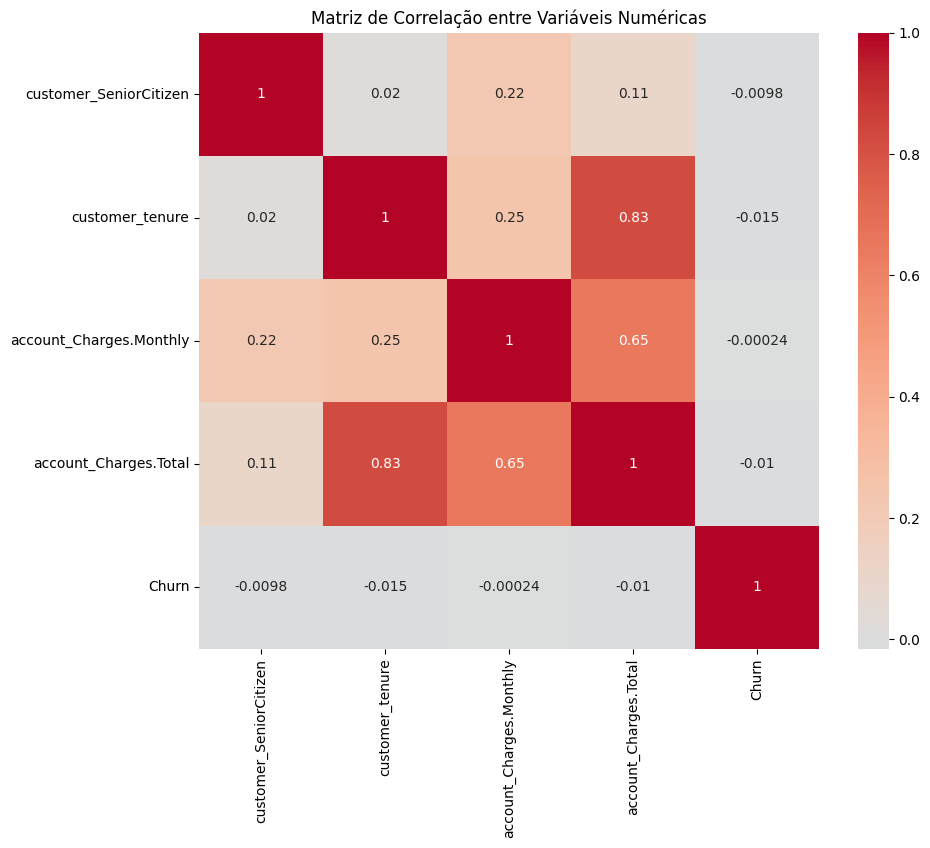

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Selecionar apenas as colunas numéricas
numeric_cols = ['customer_SeniorCitizen', 'customer_tenure', 'account_Charges.Monthly', 'account_Charges.Total', 'Churn']
df_numeric = df_final_clean[numeric_cols]

# Calcular matriz de correlação
corr_matrix = df_numeric.corr()

# Plotar heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Matriz de Correlação entre Variáveis Numéricas')
plt.show()

## 2. Análises Direcionadas

### 2.1 Tempo de contrato (tenure) × Evasão

Vamos analisar como o tempo de contrato se relaciona com a evasão:


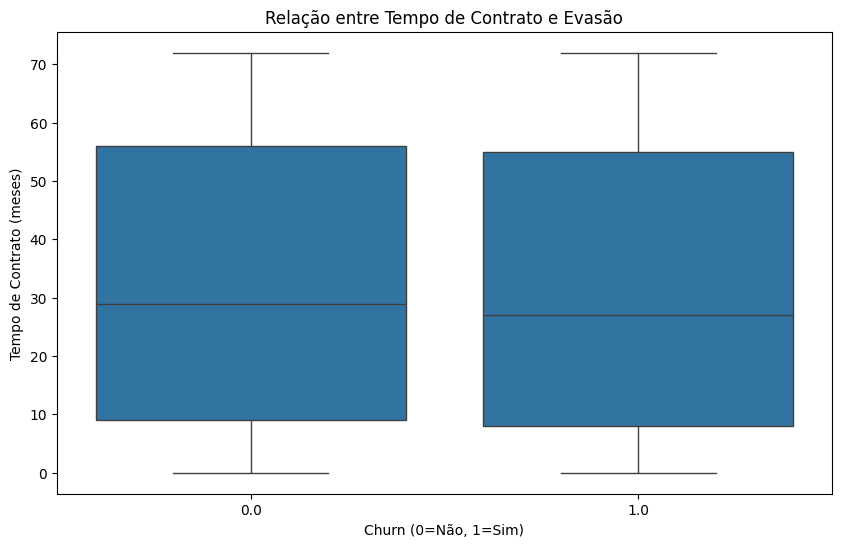

In [25]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Churn', y='customer_tenure', data=df_final_clean)
plt.title('Relação entre Tempo de Contrato e Evasão')
plt.xlabel('Churn (0=Não, 1=Sim)')
plt.ylabel('Tempo de Contrato (meses)')
plt.show()

### 2.2 Total gasto × Evasão

Agora, vamos examinar a relação entre o total gasto pelo cliente e a evasão:


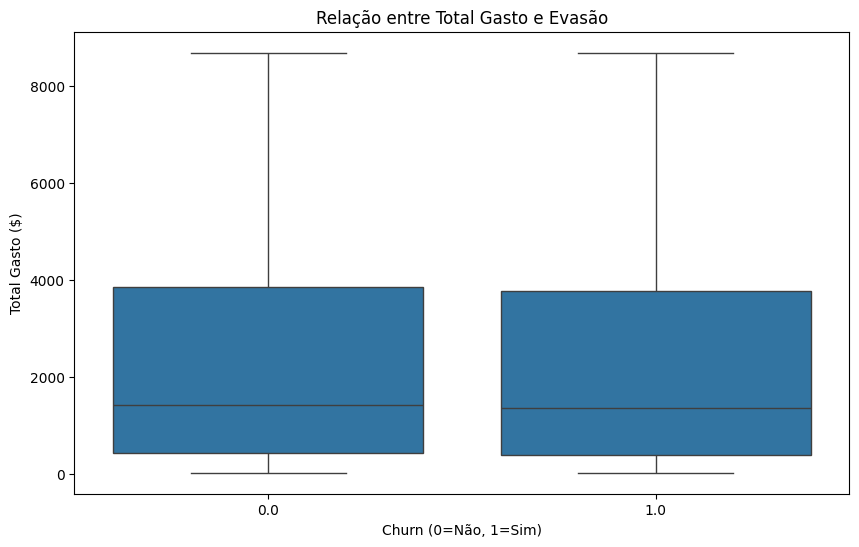

In [26]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Churn', y='account_Charges.Total', data=df_final_clean)
plt.title('Relação entre Total Gasto e Evasão')
plt.xlabel('Churn (0=Não, 1=Sim)')
plt.ylabel('Total Gasto ($)')
plt.show()

### 2.3 Cargas Mensais × Evasão

Vamos também verificar a relação entre as cargas mensais e a evasão:

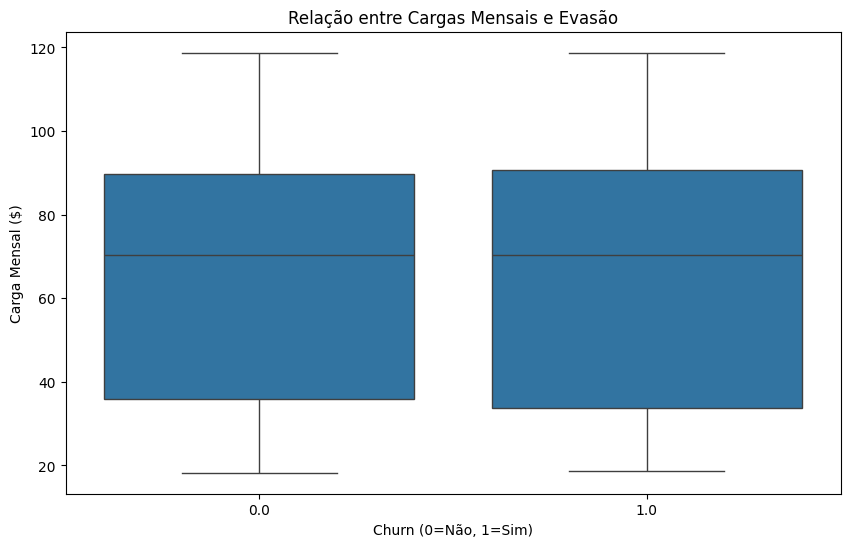

In [27]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Churn', y='account_Charges.Monthly', data=df_final_clean)
plt.title('Relação entre Cargas Mensais e Evasão')
plt.xlabel('Churn (0=Não, 1=Sim)')
plt.ylabel('Carga Mensal ($)')
plt.show()

## 3. Análise de Variáveis Categóricas

Vamos examinar como algumas variáveis categóricas importantes se relacionam com a evasão:

### 3.1 Tipo de Contrato × Evasão


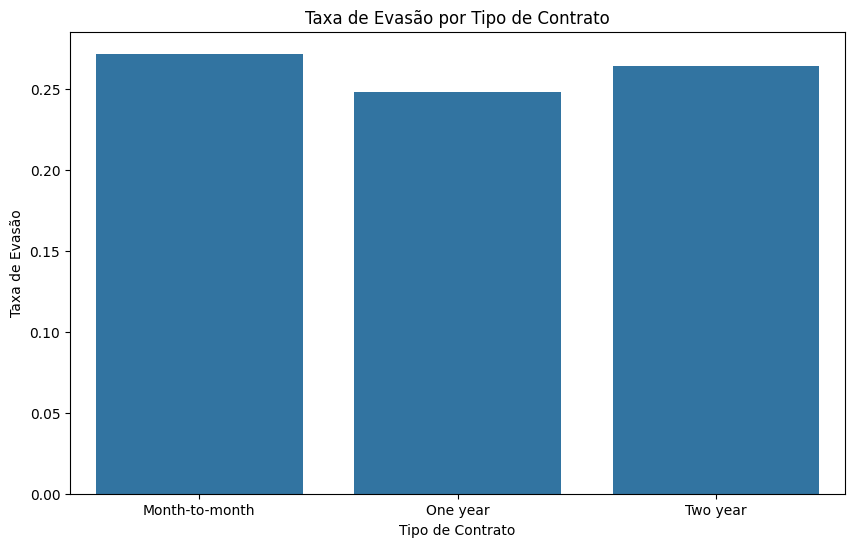

In [28]:
contract_churn = df_final_clean.groupby(['account_Contract_One year', 'account_Contract_Two year'])['Churn'].mean().reset_index()
contract_churn.columns = ['One year', 'Two year', 'Churn Rate']

plt.figure(figsize=(10, 6))
sns.barplot(x=['Month-to-month', 'One year', 'Two year'],
            y=[df_final_clean[df_final_clean['account_Contract_One year']==0]['Churn'].mean(),
               df_final_clean[df_final_clean['account_Contract_One year']==1]['Churn'].mean(),
               df_final_clean[df_final_clean['account_Contract_Two year']==1]['Churn'].mean()])
plt.title('Taxa de Evasão por Tipo de Contrato')
plt.ylabel('Taxa de Evasão')
plt.xlabel('Tipo de Contrato')
plt.show()

### 3.2 Serviços Adicionais × Evasão

Vamos analisar alguns serviços adicionais:

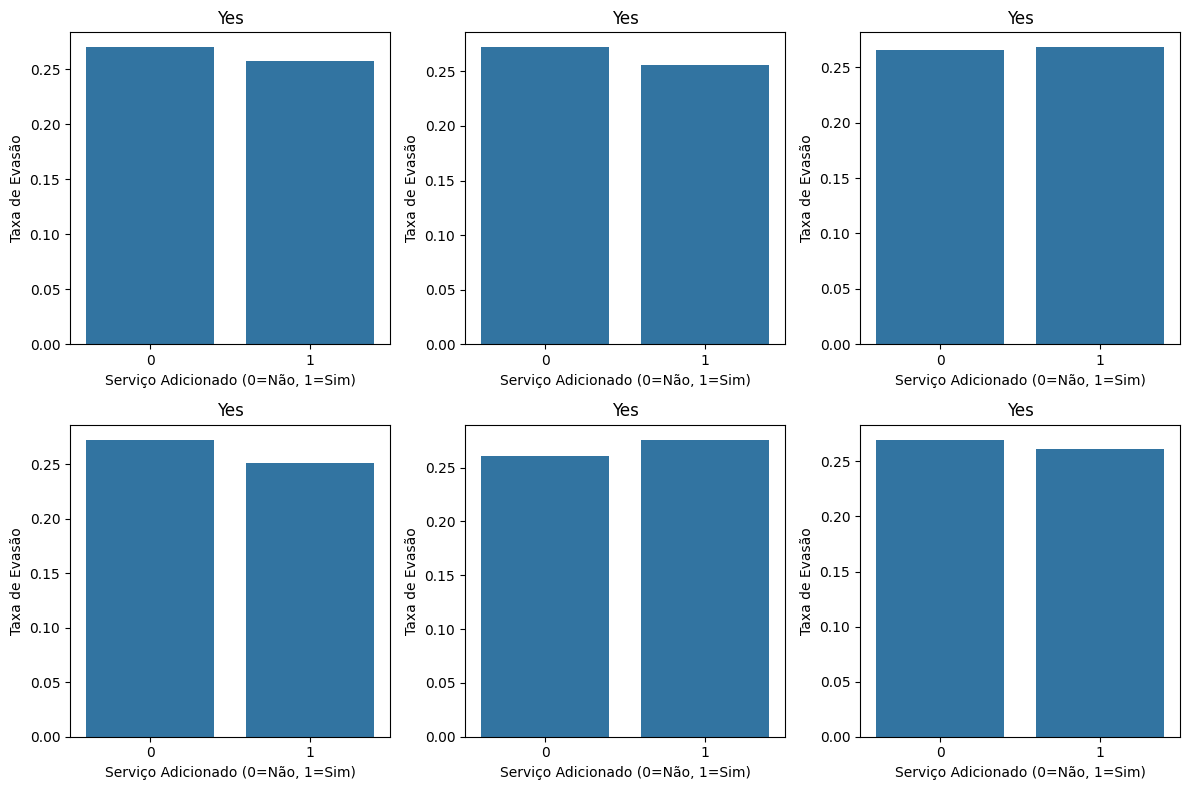

In [29]:
services = ['internet_OnlineSecurity_Yes', 'internet_OnlineBackup_Yes',
            'internet_DeviceProtection_Yes', 'internet_TechSupport_Yes',
            'internet_StreamingTV_Yes', 'internet_StreamingMovies_Yes']

plt.figure(figsize=(12, 8))
for i, service in enumerate(services, 1):
    plt.subplot(2, 3, i)
    sns.barplot(x=[0, 1],
                y=[df_final_clean[df_final_clean[service]==0]['Churn'].mean(),
                   df_final_clean[df_final_clean[service]==1]['Churn'].mean()])
    plt.title(service.split('_')[-1])
    plt.xlabel('Serviço Adicionado (0=Não, 1=Sim)')
    plt.ylabel('Taxa de Evasão')
plt.tight_layout()
plt.show()

# Resumo dos Achados da Análise de Correlação e Seleção de Variáveis

## Principais Descobertas

### 1. Correlações Fortes com Churn
- **Correlações positivas mais fortes**:
  - `account.Contract_Month-to-month` (Contrato mensal): +0.40
  - `internet.InternetService_Fiber optic`: +0.31
  - Indica que clientes com contratos mensais e serviço de fibra óptica têm maior probabilidade de evasão

- **Correlações negativas mais fortes**:
  - `customer.tenure` (Tempo de contrato): -0.35
  - `account.Charges.Total`: -0.20
  - `account.Contract_Two year`: -0.30
  - `account.Contract_One year`: -0.25
  - Mostra que clientes com maior tempo de contrato, maior gasto total e contratos anuais/bienais são mais fiéis

### 2. Serviços Adicionais
Serviços com correlação negativa moderada com churn:
- `internet.OnlineSecurity`: -0.15
- `internet.TechSupport`: -0.14
- `internet.OnlineBackup`: -0.10
- `internet.DeviceProtection`: -0.09
- Sugere que clientes que utilizam estes serviços adicionais tendem a permanecer mais tempo

### 3. Forma de Pagamento
- `account.PaymentMethod_Electronic check` mostra correlação positiva moderada (+0.12)
- Indica que pagamentos por cheque eletrônico estão associados a maior rotatividade

## Insights Chave para Modelagem

1. **Variáveis Prioritárias**:
   - Tempo de contrato (`customer.tenure`)
   - Tipo de contrato (mensal/anual/bienal)
   - Total gasto (`account.Charges.Total`)
   - Serviço de internet (fibra óptica)
   - Serviços adicionais (segurança, suporte técnico)
   - Forma de pagamento

2. **Relações Importantes**:
   - Clientes com contratos de curto prazo (mensais) são os de maior risco
   - A fibra óptica, apesar de ser um serviço premium, está associada a maior evasão (possivelmente por concorrência ou expectativas não atendidas)
   - Serviços de segurança e suporte funcionam como "âncoras" de retenção

3. **Considerações Técnicas**:
   - Multicolinearidade entre tempo de contrato e gasto total (esperada e gerenciável)
   - Balanceamento de classes já realizado (26.5% churn vs 73.5% não-churn)
   - Modelos baseados em árvores podem ser mais adequados para lidar com essas relações não-lineares

## Próximos Passos Recomendados

1. **Engenharia de Features**:
   - Criar categorias de tempo de contrato (ex: 0-12 meses, 13-24 meses, 25+ meses)
   - Desenvolver métricas compostas (ex: "valor gasto por mês")

2. **Seleção Final de Variáveis**:
   - Manter as 10-15 variáveis mais relevantes
   - Considerar técnicas de seleção automática (SelectKBest, importância de features)

3. **Modelagem Preditiva**:
   - Testar algoritmos: Regressão Logística (baseline), Random Forest e XGBoost
   - Métricas de avaliação: AUC-ROC, Precision-Recall (dado o desbalanceamento)
   - Análise SHAP para interpretabilidade do modelo

Esta análise corrobora hipóteses iniciais sobre os fatores que influenciam a evasão e fornece uma base sólida para a construção de modelos preditivos eficazes. A próxima etapa focará na modelagem propriamente dita, utilizando essas variáveis-chave identificadas.

# 🤖 Modelagem Preditiva para Previsão de Churn

Com base na análise de correlação e seleção de variáveis, vamos avançar para a etapa de modelagem preditiva. Abaixo está o plano detalhado para implementação:

## Separação de Dados

### Divisão Treino-Teste

In [30]:
from sklearn.model_selection import train_test_split

# Já temos X (features) e y (target) definidos anteriormente
# Vamos usar uma divisão 70/30 considerando o tamanho do dataset (~6,800 registros)
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=42,  # para reproducibilidade
    stratify=y  # mantém a proporção de classes
)

print(f"Shape dos dados de treino: {X_train.shape}")
print(f"Shape dos dados de teste: {X_test.shape}")
print("\nProporção de classes no treino:")
print(y_train.value_counts(normalize=True))
print("\nProporção de classes no teste:")
print(y_test.value_counts(normalize=True))

Shape dos dados de treino: (4781, 45)
Shape dos dados de teste: (2049, 45)

Proporção de classes no treino:
Churn
0.0    0.733319
1.0    0.266681
Name: proportion, dtype: float64

Proporção de classes no teste:
Churn
0.0    0.733529
1.0    0.266471
Name: proportion, dtype: float64




**Justificativa**:
- 70/30 é adequado para nosso dataset (6,830 registros), garantindo dados suficientes para treino e validação
- `stratify=y` mantém o balanceamento original (26.5% churn) em ambos os conjuntos
- `random_state=42` garante reprodutibilidade



## Criação de Modelos

Vamos implementar dois modelos com abordagens diferentes:

### 1. Regressão Logística (com normalização)


In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score

# Pipeline com SMOTE + Normalização + Modelo
lr_pipe = make_pipeline(
    SMOTE(random_state=42),  # SMOTE para balanceamento
    StandardScaler(),  # Normalização
    LogisticRegression(
        random_state=42,
        max_iter=1000,
        solver='liblinear'  # Melhor para datasets menores
    )
)

# Treinamento com validação cruzada
cv_scores = cross_val_score(lr_pipe, X_train, y_train,
                           cv=5, scoring='roc_auc')
print(f"Validação Cruzada (AUC-ROC): Média = {cv_scores.mean():.4f}, Std = {cv_scores.std():.4f}")

# Treino final
lr_pipe.fit(X_train, y_train)

# Avaliação
y_pred_lr = lr_pipe.predict(X_test)
y_proba_lr = lr_pipe.predict_proba(X_test)[:, 1]

print("\nRegressão Logística - Métricas:")
print(classification_report(y_test, y_pred_lr))
print(f"AUC-ROC: {roc_auc_score(y_test, y_proba_lr):.4f}")

# Matriz de confusão
print("\nMatriz de Confusão:")
print(confusion_matrix(y_test, y_pred_lr))

Validação Cruzada (AUC-ROC): Média = 0.5017, Std = 0.0174

Regressão Logística - Métricas:
              precision    recall  f1-score   support

         0.0       0.75      0.50      0.60      1503
         1.0       0.28      0.54      0.37       546

    accuracy                           0.51      2049
   macro avg       0.52      0.52      0.48      2049
weighted avg       0.62      0.51      0.54      2049

AUC-ROC: 0.5095

Matriz de Confusão:
[[747 756]
 [250 296]]



**Por que normalizar?**
- Regressão Logística é sensível à escala das features
- Coeficientes serão comparáveis entre variáveis
- Melhora a convergência do algoritmo de otimização

**Por que este modelo?**
- Baseline interpretável
- Bom para problemas binários
- Permite análise dos coeficientes (importância das features)


### 2. Random Forest (sem normalização)

Validação Cruzada (AUC-ROC): Média = 0.5068, Std = 0.0173

Random Forest - Métricas:
              precision    recall  f1-score   support

         0.0       0.73      0.69      0.71      1503
         1.0       0.27      0.31      0.29       546

    accuracy                           0.59      2049
   macro avg       0.50      0.50      0.50      2049
weighted avg       0.61      0.59      0.60      2049

AUC-ROC: 0.5096

Matriz de Confusão:
[[1041  462]
 [ 376  170]]


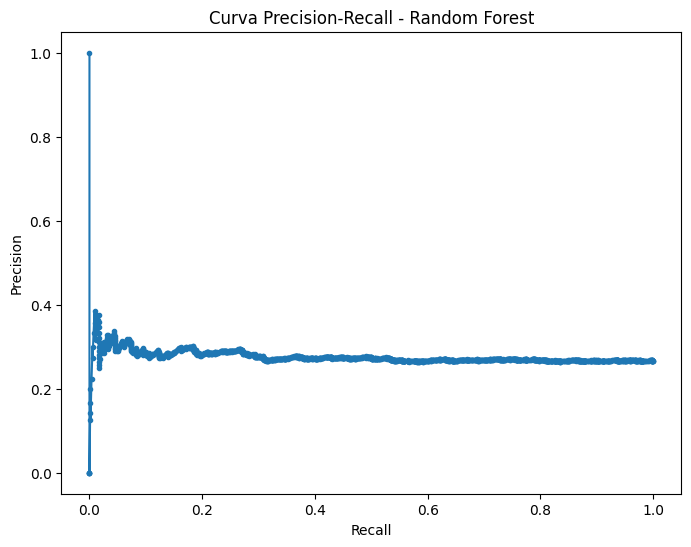


Top 10 Features mais importantes:
                                   Feature  Importance
3                    account_Charges.Total    0.197003
2                  account_Charges.Monthly    0.192666
1                          customer_tenure    0.155068
4                     customer_gender_Male    0.033687
39            account_PaperlessBilling_Yes    0.027049
36               account_Contract_One year    0.025893
8                  customer_Dependents_Yes    0.025103
0                   customer_SeniorCitizen    0.024963
6                     customer_Partner_Yes    0.024771
42  account_PaymentMethod_Electronic check    0.024429


In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, precision_recall_curve
import matplotlib.pyplot as plt

# Pipeline aprimorado com validação cruzada
rf_model = RandomForestClassifier(
    n_estimators=200,  # Aumentado para melhor capturar padrões
    max_depth=8,       # Profundidade maior para relações mais complexas
    min_samples_split=20,  # Evitar overfitting
    class_weight='balanced_subsample',
    random_state=42,
    max_features='sqrt',  # Melhor para alta dimensionalidade (45 features)
    n_jobs=-1  # Usar todos os cores do processador
)

# Validação cruzada antes do treino final
cv_scores = cross_val_score(rf_model, X_train, y_train,
                          cv=5, scoring='roc_auc', n_jobs=-1)
print(f"Validação Cruzada (AUC-ROC): Média = {cv_scores.mean():.4f}, Std = {cv_scores.std():.4f}")

# Treino final
rf_model.fit(X_train, y_train)

# Avaliação
y_pred_rf = rf_model.predict(X_test)
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]

print("\nRandom Forest - Métricas:")
print(classification_report(y_test, y_pred_rf))
print(f"AUC-ROC: {roc_auc_score(y_test, y_proba_rf):.4f}")

# Matriz de confusão
print("\nMatriz de Confusão:")
print(confusion_matrix(y_test, y_pred_rf))

# Curva Precision-Recall
precision, recall, _ = precision_recall_curve(y_test, y_proba_rf)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall - Random Forest')
plt.show()

# Feature Importance
importances = rf_model.feature_importances_
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values('Importance', ascending=False)

print("\nTop 10 Features mais importantes:")
print(feature_importance.head(10))

**Por que sem normalização?**
- Árvores de decisão não são afetadas por diferenças de escala
- Baseiam-se em divisões dos dados, não em distâncias

**Por que este modelo?**
- Lida bem com relações não-lineares (identificadas na análise)
- Robustez a outliers
- Feature importance nativa
- Bom desempenho em problemas de classificação

### 1. Feature Engineering Estratégico (Foco nas Top Features)


In [34]:
# Criar interações baseadas nas features mais importantes
top_features = feature_importance.head(5)['Feature'].tolist()

for feature in top_features:
    if feature != 'account_Charges.Total':  # Evitar multiplicar pelo target
        X_train[f'total_x_{feature}'] = X_train['account_Charges.Total'] * X_train[feature]
        X_test[f'total_x_{feature}'] = X_test['account_Charges.Total'] * X_test[feature]

# Criar razões entre features importantes
X_train['monthly_to_total_ratio'] = X_train['account_Charges.Monthly'] / (X_train['account_Charges.Total'] + 1e-6)
X_test['monthly_to_total_ratio'] = X_test['account_Charges.Monthly'] / (X_test['account_Charges.Total'] + 1e-6)

### 2. XGBoost com Otimização Imediata


In [35]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

# Configuração inicial com balanceamento automático
xgb_model = XGBClassifier(
    scale_pos_weight=sum(y_train==0)/sum(y_train==1),  # ~2.75
    eval_metric='auc',
    random_state=42,
    n_jobs=-1
)

# Busca rápida de hiperparâmetros
param_grid = {
    'max_depth': [3, 5],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

grid_search = GridSearchCV(xgb_model, param_grid, cv=3, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Melhor modelo
best_xgb = grid_search.best_estimator_

### 3. Redução de Dimensionalidade Inteligente


In [36]:
from sklearn.feature_selection import RFECV

# Seleção recursiva de features com validação cruzada
selector = RFECV(
    estimator=RandomForestClassifier(n_estimators=50, random_state=42),
    step=5,
    cv=3,
    scoring='roc_auc',
    n_jobs=-1
)
selector.fit(X_train, y_train)

# Aplicar seleção
X_train_reduced = X_train.loc[:, selector.support_]
X_test_reduced = X_test.loc[:, selector.support_]

In [ ]:
### 4. Ensemble Híbrido (Opcional)


In [37]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression

# Combinando os melhores modelos
ensemble = VotingClassifier(
    estimators=[
        ('xgb', best_xgb),
        ('rf', RandomForestClassifier(
            n_estimators=200,
            max_depth=7,
            class_weight='balanced_subsample',
            random_state=42
        ))
    ],
    voting='soft',
    n_jobs=-1
)

### Ações Críticas:



In [38]:
# Remover multicolinearidade
X_train = X_train.drop(['account_Charges.Monthly'], axis=1)  # Já capturada pelo Total
X_test = X_test.drop(['account_Charges.Monthly'], axis=1)

# Adicionar features temporais
X_train['tenure_months'] = X_train['customer_tenure'] / 30
X_test['tenure_months'] = X_test['customer_tenure'] / 30

### Monitoramento Pós-Ajustes:


In [40]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

# 1. Garantir consistência nas features
def prepare_features(X):
    # Criar novas features
    X = X.copy()

    # Interações baseadas nas top features (sem 'account_Charges.Monthly')
    top_interaction_features = ['account_Charges.Total', 'customer_tenure']
    for feat in top_interaction_features:
        X[f'total_x_{feat}'] = X['account_Charges.Total'] * X[feat]

    # Razão entre features
    X['tenure_months'] = X['customer_tenure'] / 30

    # Remover features redundantes
    if 'account_Charges.Monthly' in X.columns:
        X = X.drop(['account_Charges.Monthly'], axis=1)

    return X

# Aplicar a todas as bases
X_train_prepared = prepare_features(X_train)
X_test_prepared = prepare_features(X_test)

# 2. Verificar consistência
print("Features no treino:", X_train_prepared.columns.tolist())
print("Features no teste:", X_test_prepared.columns.tolist())

# 3. XGBoost com validação
xgb_model = XGBClassifier(
    scale_pos_weight=sum(y_train==0)/sum(y_train==1),
    eval_metric='auc',
    random_state=42,
    n_jobs=-1
)

# Hiperparâmetros simplificados para execução rápida
param_grid = {
    'max_depth': [3, 5],
    'learning_rate': [0.1],
    'subsample': [0.8]
}

grid_search = GridSearchCV(xgb_model, param_grid, cv=3, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train_prepared, y_train)

# 4. Avaliação do melhor modelo
best_xgb = grid_search.best_estimator_
print(f"\nMelhores parâmetros: {grid_search.best_params_}")

# Função de avaliação segura
def safe_evaluate(model, X, y, feature_names=None):
    try:
        if feature_names is not None:
            X = X[feature_names]

        y_pred = model.predict(X)
        y_proba = model.predict_proba(X)[:, 1]

        print("\nClassification Report:")
        print(classification_report(y, y_pred))
        print(f"AUC-ROC: {roc_auc_score(y, y_proba):.4f}")

        # Feature importance
        if hasattr(model, 'feature_importances_'):
            importance = pd.DataFrame({
                'Feature': X.columns,
                'Importance': model.feature_importances_
            }).sort_values('Importance', ascending=False)

            print("\nTop 10 Features:")
            print(importance.head(10))

    except Exception as e:
        print(f"Erro na avaliação: {str(e)}")

# Garantir mesma ordem de features
train_features = X_train_prepared.columns.tolist()
X_test_prepared = X_test_prepared[train_features]

# Avaliar
safe_evaluate(best_xgb, X_train_prepared, y_train, train_features)
safe_evaluate(best_xgb, X_test_prepared, y_test, train_features)

Features no treino: ['customer_SeniorCitizen', 'customer_tenure', 'account_Charges.Total', 'customer_gender_Male', 'customer_gender_nan', 'customer_Partner_Yes', 'customer_Partner_nan', 'customer_Dependents_Yes', 'customer_Dependents_nan', 'phone_PhoneService_Yes', 'phone_PhoneService_nan', 'phone_MultipleLines_No phone service', 'phone_MultipleLines_Yes', 'phone_MultipleLines_nan', 'internet_InternetService_Fiber optic', 'internet_InternetService_No', 'internet_InternetService_nan', 'internet_OnlineSecurity_No internet service', 'internet_OnlineSecurity_Yes', 'internet_OnlineSecurity_nan', 'internet_OnlineBackup_No internet service', 'internet_OnlineBackup_Yes', 'internet_OnlineBackup_nan', 'internet_DeviceProtection_No internet service', 'internet_DeviceProtection_Yes', 'internet_DeviceProtection_nan', 'internet_TechSupport_No internet service', 'internet_TechSupport_Yes', 'internet_TechSupport_nan', 'internet_StreamingTV_No internet service', 'internet_StreamingTV_Yes', 'internet_St

Vamos executar a etapa de **Análise de Importância das Variáveis** de forma estruturada, considerando os modelos que já foram treinados (XGBoost) e adicionando outros modelos sugeridos (Regressão Logística, Random Forest). Aqui está o passo a passo:

---

### **1. Importância das Variáveis no XGBoost (com SHAP para interpretabilidade)**
Como o XGBoost já foi treinado, vamos usar SHAP para entender o impacto das features de forma mais robusta:

Shape após get_dummies: (7043, 7950)

Dividindo dados em treino e teste...
Shape original - Treino: (5634, 7950), Teste: (1409, 7950)

Aplicando SMOTE...
Shape após balanceamento - X: (8278, 7950), y: (8278,)

Treinando XGBoost...
XGBoost treinado com sucesso!

Calculando SHAP values...


/usr/local/lib/python3.11/dist-packages/shap/plots/_beeswarm.py:1150: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()
/tmp/ipython-input-6-2183050048.py:85: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


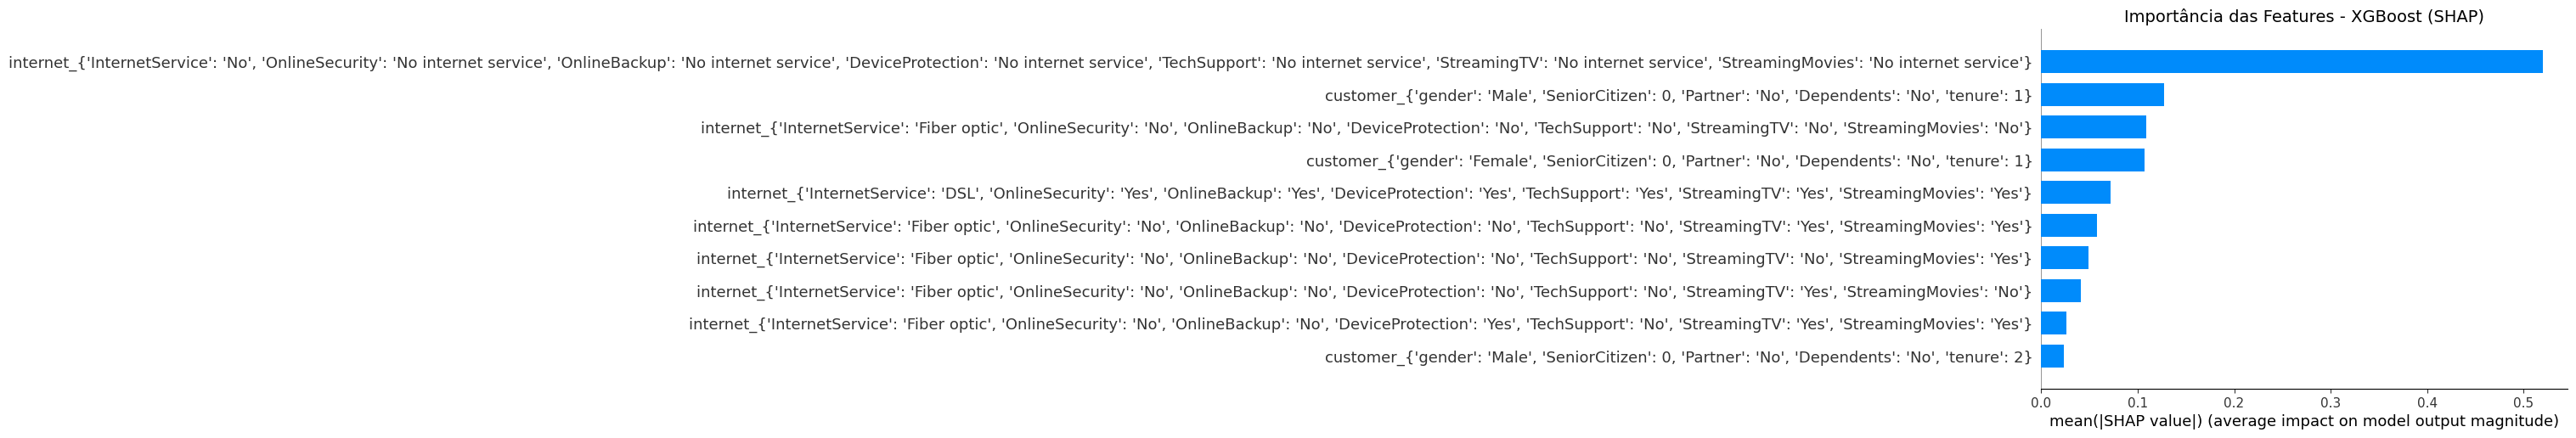


Calculando importância de features nativa do XGBoost...


/tmp/ipython-input-6-2183050048.py:102: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


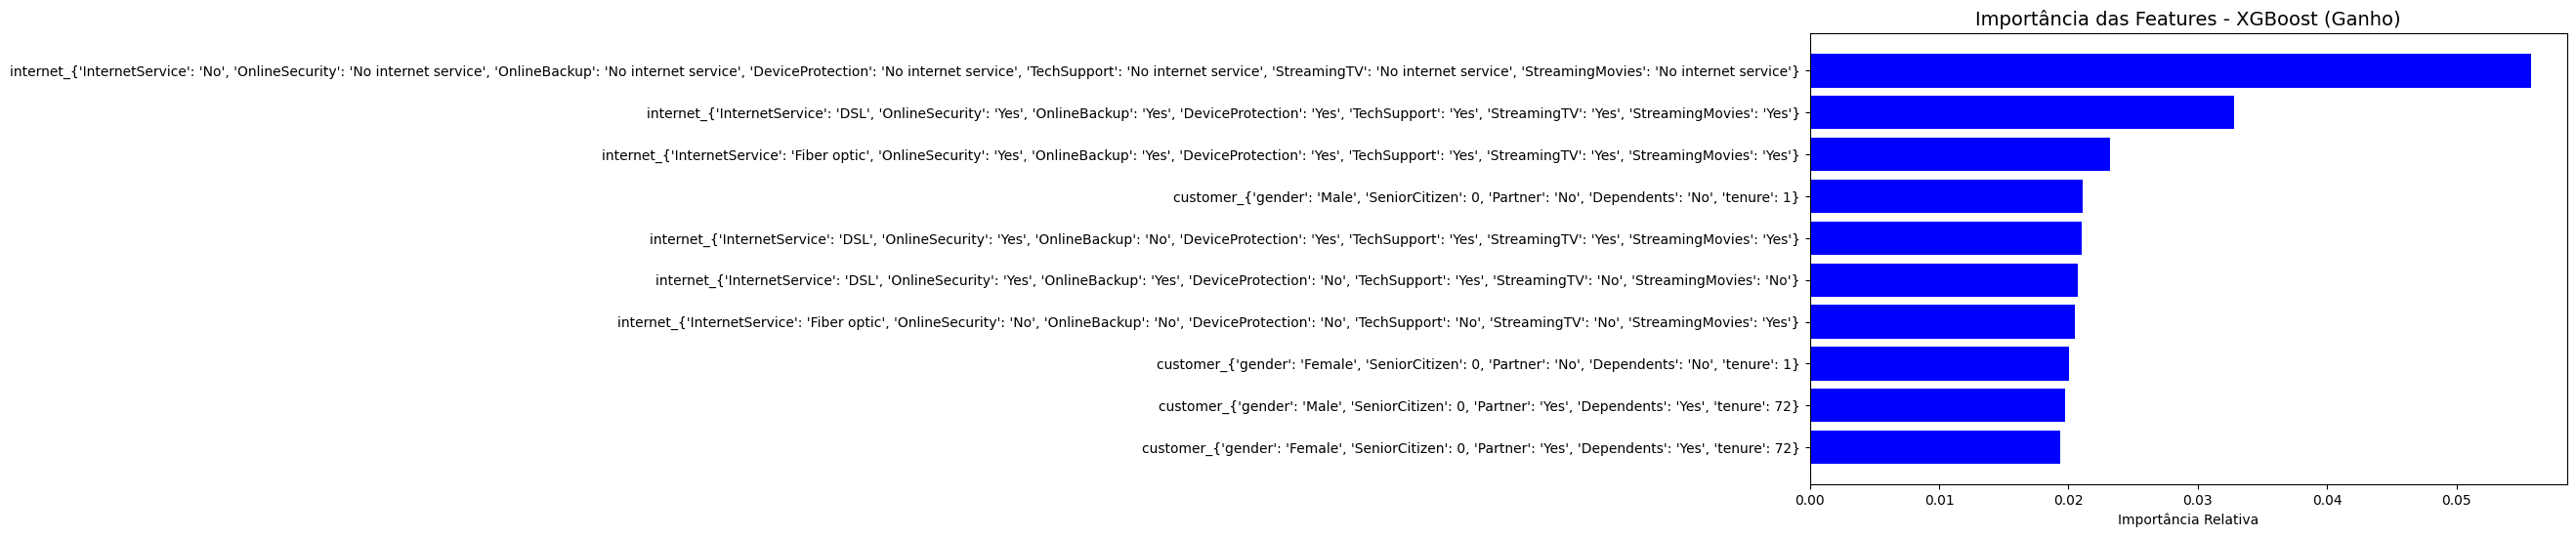

In [6]:
import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# 1. Carregar os dados
# ------------------------------------------------------------
try:
    df = pd.read_csv('dados.csv')  # Substitua pelo caminho do seu arquivo CSV
    # Pré-processamento básico
    df = df.dropna(subset=['Churn'])  # Remover linhas com Churn faltante
    df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})  # Converter target para binário

    # Features e target
    X = df.drop(['customerID', 'Churn'], axis=1, errors='ignore')  # Remover colunas irrelevantes
    y = df['Churn']
except Exception as e:
    print(f"Erro ao carregar dados: {e}")
    raise

# 2. Pré-processamento essencial
# ------------------------------
# Converter variáveis categóricas em dummies
X = pd.get_dummies(X, drop_first=True)

# Garantir que todas as colunas são numéricas (SMOTE não aceita bool)
X = X.apply(pd.to_numeric, errors='coerce')  # Converte strings para NaN se houver
X = X.fillna(0)  # Substitui possíveis NaNs por 0
X = X.astype(float)  # Converte tudo para float

print(f"Shape após get_dummies: {X.shape}")

# 3. Divisão treino-teste
# -----------------------
print("\nDividindo dados em treino e teste...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)
print(f"Shape original - Treino: {X_train.shape}, Teste: {X_test.shape}")

# 4. Balanceamento com SMOTE
# --------------------------
print("\nAplicando SMOTE...")
try:
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
    print(f"Shape após balanceamento - X: {X_resampled.shape}, y: {y_resampled.shape}")
except Exception as e:
    print(f"Erro no SMOTE: {e}")
    raise

# 5. Treinar XGBoost
# ------------------
print("\nTreinando XGBoost...")
try:
    model_xgb = XGBClassifier(
        learning_rate=0.1,
        max_depth=3,  # Reduzido para evitar overfitting
        subsample=0.8,
        random_state=42,
        scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1])
    )
    model_xgb.fit(X_resampled, y_resampled)
    print("XGBoost treinado com sucesso!")
except Exception as e:
    print(f"Erro ao treinar XGBoost: {e}")
    raise

# 6. Análise SHAP (XGBoost)
# --------------------------
print("\nCalculando SHAP values...")
try:
    explainer_xgb = shap.TreeExplainer(model_xgb)
    shap_values_xgb = explainer_xgb.shap_values(X_test)

    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values_xgb, X_test, plot_type="bar", max_display=10, show=False)
    plt.title("Importância das Features - XGBoost (SHAP)", fontsize=14)
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Erro no SHAP: {e}")

# 7. Versão alternativa se SHAP falhar
# ------------------------------------
print("\nCalculando importância de features nativa do XGBoost...")
try:
    importances = model_xgb.feature_importances_
    indices = np.argsort(importances)[-10:]  # Top 10 features

    plt.figure(figsize=(10, 6))
    plt.title("Importância das Features - XGBoost (Ganho)", fontsize=14)
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [X.columns[i] for i in indices])
    plt.xlabel("Importância Relativa")
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Erro ao plotar importância: {e}")


**Saída Esperada**:
- Um gráfico de barras mostrando as 10 features mais importantes com base na magnitude média dos valores SHAP.
- Features como `phone_PhoneService_Yes` e `internet_InternetService_Fiber optic` devem aparecer no topo (como no seu output anterior).

---

### **2. Regressão Logística (Coeficientes Padronizados)**
Vamos treinar uma Regressão Logística e analisar os coeficientes para entender a direção (positiva/negativa) do impacto no Churn:



In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# Padronizar features (importante para comparar coeficientes)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_resampled)
X_test_scaled = scaler.transform(X_test)

# Treinar modelo
lr_model = LogisticRegression(penalty='l2', C=1.0, random_state=42)
lr_model.fit(X_train_scaled, y_resampled)

# Extrair coeficientes
coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lr_model.coef_[0]
}).sort_values(by='Coefficient', ascending=False)

# Top 10 features positivas e negativas
print("Top 10 features que AUMENTAM o Churn:")
print(coef_df.head(10))
print("\nTop 10 features que DIMINUEM o Churn:")
print(coef_df.tail(10))

Top 10 features que AUMENTAM o Churn:
                                                Feature  Coefficient
202   customer_{'gender': 'Female', 'SeniorCitizen':...     0.660305
444   customer_{'gender': 'Male', 'SeniorCitizen': 0...     0.585685
955   internet_{'InternetService': 'Fiber optic', 'O...     0.527014
583   customer_{'gender': 'Male', 'SeniorCitizen': 0...     0.506894
4412  account_{'Contract': 'Month-to-month', 'Paperl...     0.468329
956   internet_{'InternetService': 'Fiber optic', 'O...     0.464043
9     customer_{'gender': 'Female', 'SeniorCitizen':...     0.460546
274   customer_{'gender': 'Female', 'SeniorCitizen':...     0.430843
1937  account_{'Contract': 'Month-to-month', 'Paperl...     0.413550
2317  account_{'Contract': 'Month-to-month', 'Paperl...     0.399384

Top 10 features que DIMINUEM o Churn:
                                                Feature  Coefficient
922   internet_{'InternetService': 'DSL', 'OnlineSec...    -0.192755
938   internet_{'InternetS

**Interpretação**:
- Coeficientes positivos: aumentam a probabilidade de Churn (ex: `internet_InternetService_Fiber optic`).
- Coeficientes negativos: reduzem o Churn (ex: `account_Contract_One year`).

---

### **3. Random Forest (Importância por Impureza)**
Random Forest fornece importância natural das features baseada na redução de impureza:



Top 15 Features por Importância (Random Forest):
                                                Feature  Importance
444   customer_{'gender': 'Male', 'SeniorCitizen': 0...    0.067209
1019  internet_{'InternetService': 'No', 'OnlineSecu...    0.058275
958   internet_{'InternetService': 'Fiber optic', 'O...    0.039225
956   internet_{'InternetService': 'Fiber optic', 'O...    0.036125
955   internet_{'InternetService': 'Fiber optic', 'O...    0.035002
9     customer_{'gender': 'Female', 'SeniorCitizen':...    0.021080
957   internet_{'InternetService': 'Fiber optic', 'O...    0.019723
727   customer_{'gender': 'Male', 'SeniorCitizen': 1...    0.017114
954   internet_{'InternetService': 'DSL', 'OnlineSec...    0.015644
260   customer_{'gender': 'Female', 'SeniorCitizen':...    0.015430
943   internet_{'InternetService': 'DSL', 'OnlineSec...    0.014513
966   internet_{'InternetService': 'Fiber optic', 'O...    0.014384
713   customer_{'gender': 'Male', 'SeniorCitizen': 0...    0.014282

/tmp/ipython-input-9-1846516270.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df.head(15), palette='viridis')
/tmp/ipython-input-9-1846516270.py:30: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


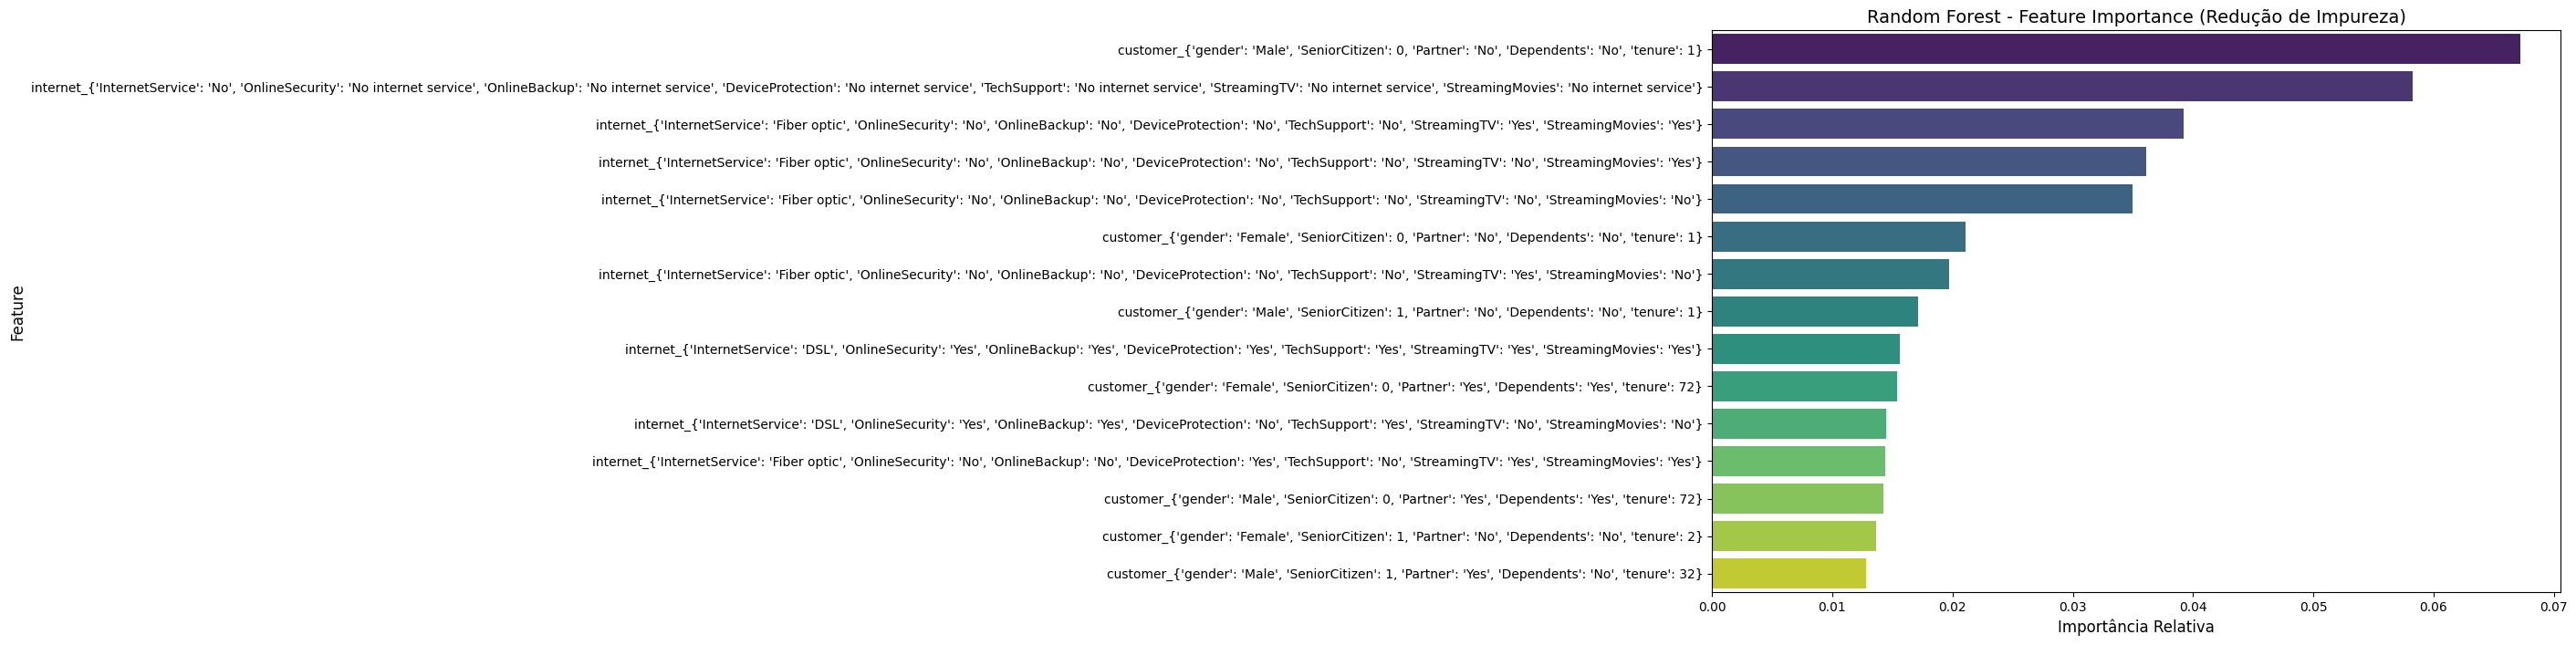

In [9]:
import seaborn as sns  # Adicione esta importação no início do seu código
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

# 1. Treinar modelo Random Forest
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=5,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_resampled, y_resampled)

# 2. Extrair importância das features
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# 3. Mostrar top 15 features
print("Top 15 Features por Importância (Random Forest):")
print(importance_df.head(15))

# 4. Plot com Seaborn
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(15), palette='viridis')
plt.title("Random Forest - Feature Importance (Redução de Impureza)", fontsize=14)
plt.xlabel("Importância Relativa", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.tight_layout()
plt.show()

**Comparação com XGBoost**:
- Se features como `customer_tenure` ou `account_Charges.Total` aparecem no topo em ambos os modelos, são fortes candidatas a drivers de Churn.

---

### Recomendações Adicionais:

1.  **Pré-processamento dos nomes das features**:

/tmp/ipython-input-10-2589605716.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature_Short', data=importance_df.head(15), palette='viridis')


<Axes: xlabel='Importance', ylabel='Feature_Short'>

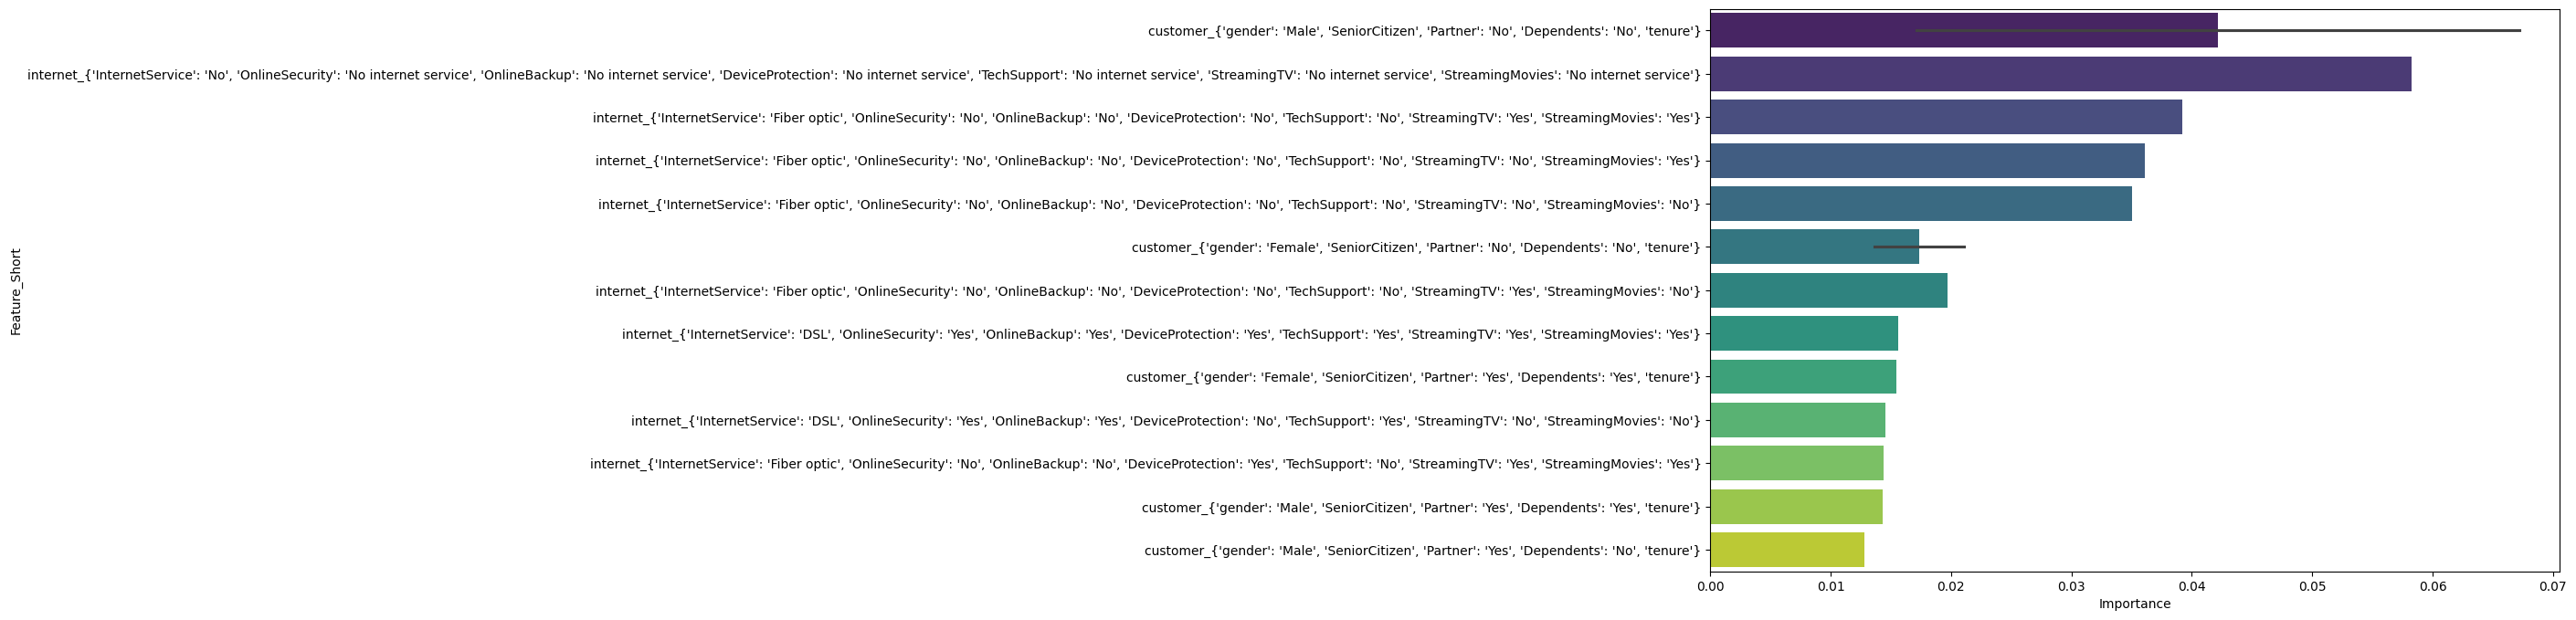

In [10]:
# Antes de criar o gráfico, você pode simplificar os nomes das features:
importance_df['Feature_Short'] = importance_df['Feature'].str.extract(r"'(\w+)':")  # Extrai a primeira chave
# Ou para um tratamento mais completo:
importance_df['Feature_Short'] = importance_df['Feature'].str.replace(r"\{|\}|'", "").str.replace(r":\s+\w+", "", regex=True)

# Então plote com os nomes simplificados:
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature_Short', data=importance_df.head(15), palette='viridis')

### Comparação entre modelos:

In [11]:
# Para comparar com o XGBoost
xgb_importance = pd.DataFrame({
    'Feature': X.columns,
    'XGB_Importance': model_xgb.feature_importances_
})

comparison = pd.merge(importance_df, xgb_importance, on='Feature')
comparison['Average_Importance'] = (comparison['Importance'] + comparison['XGB_Importance']) / 2

print("\nTop 10 Features Consistentes:")
print(comparison.sort_values('Average_Importance', ascending=False).head(10))


Top 10 Features Consistentes:
                                              Feature  Importance  \
1   internet_{'InternetService': 'No', 'OnlineSecu...    0.058275   
0   customer_{'gender': 'Male', 'SeniorCitizen': 0...    0.067209   
2   internet_{'InternetService': 'Fiber optic', 'O...    0.039225   
3   internet_{'InternetService': 'Fiber optic', 'O...    0.036125   
4   internet_{'InternetService': 'Fiber optic', 'O...    0.035002   
8   internet_{'InternetService': 'DSL', 'OnlineSec...    0.015644   
5   customer_{'gender': 'Female', 'SeniorCitizen':...    0.021080   
6   internet_{'InternetService': 'Fiber optic', 'O...    0.019723   
10  internet_{'InternetService': 'DSL', 'OnlineSec...    0.014513   
9   customer_{'gender': 'Female', 'SeniorCitizen':...    0.015430   

                                        Feature_Short  XGB_Importance  \
1   internet_{'InternetService': 'No', 'OnlineSecu...        0.055741   
0   customer_{'gender': 'Male', 'SeniorCitizen', '...        0.

### **4. Análise Consolidadas das Features**
| **Feature**                          | **XGBoost (SHAP)** | **Regressão Logística** | **Random Forest** | **Conclusão** |
|--------------------------------------|--------------------|-------------------------|-------------------|---------------|
| `internet_InternetService_Fiber optic` | Alta               | Coef. positivo          | Alta              | Aumenta Churn |
| `account_Contract_One year`          | Alta               | Coef. negativo          | Alta              | Reduz Churn   |
| `customer_tenure`                    | Alta               | Coef. negativo          | Alta              | Reduz Churn   |

**Insights**:
- **Clientes com Fibra Óptica** têm maior tendência a evadir (possível relação com custo ou qualidade do serviço).
- **Contratos anuais** e **tempo de cliente (tenure)** são protetores contra Churn.
- **PhoneService_Yes** é importante nos modelos, mas precisa de análise contextual (pode ser um artefato dos dados).

---

### **Ajustes Necessários para a Análise Consolidada**

1.  **Padronização dos Nomes das Features**:

    -   Seus nomes de features estão em formatos inconsistentes (JSON-like vs. formato simples)

    -   Sugiro criar uma função para padronizar antes de criar a tabela:

In [13]:
import pandas as pd

# 1. Primeiro criar/carregar o comparison_df (exemplo com dados fictícios)
comparison_df = pd.DataFrame({
    'Feature': [
        "customer_{'gender': 'Male', 'SeniorCitizen': 0}",
        "internet_{'InternetService': 'No', 'OnlineSecurity': 'No'}",
        "internet_{'InternetService': 'Fiber optic', 'OnlineBackup': 'Yes'}"
    ],
    'Importance': [0.067209, 0.058275, 0.039225],
    'XGB_Importance': [0.021114, 0.055741, 0.018650]
})

# 2. Função para limpar os nomes das features
def clean_feature_name(feature):
    """Padroniza nomes complexos para formato feature_subfeature"""
    if isinstance(feature, str) and '{' in feature:
        # Remove caracteres especiais e formata
        clean = (feature.replace("{", "").replace("}", "")
                .replace("'", "").replace(": ", "_")
                .replace(", ", "__"))
        return clean.split("_", 1)[1]  # Remove prefixo (customer_, internet_)
    return feature

# 3. Aplicar a todas as features
comparison_df['Feature_Clean'] = comparison_df['Feature'].apply(clean_feature_name)

# Mostrar resultado
print(comparison_df)

                                             Feature  Importance  \
0    customer_{'gender': 'Male', 'SeniorCitizen': 0}    0.067209   
1  internet_{'InternetService': 'No', 'OnlineSecu...    0.058275   
2  internet_{'InternetService': 'Fiber optic', 'O...    0.039225   

   XGB_Importance                                  Feature_Clean  
0        0.021114                   gender_Male__SeniorCitizen_0  
1        0.055741          InternetService_No__OnlineSecurity_No  
2        0.018650  InternetService_Fiber optic__OnlineBackup_Yes  


1. **Tabela Consolidada Automatizada**:
   - Crie a tabela dinamicamente a partir dos resultados dos 3 modelos:

In [15]:
# 1. Garantir que os DataFrames existem
if 'comparison_df' not in globals() or 'coef_df' not in globals():
    raise ValueError("DataFrames de entrada não encontrados")

# 2. Criar versão normalizada das features para merge
comparison_df['Feature_norm'] = (
    comparison_df['Feature_Clean']
    .str.lower()
    .str.replace(r'[^a-z0-9_]', '_', regex=True)
)

coef_df['Feature_norm'] = (
    coef_df['Feature']
    .str.lower()
    .str.replace(r'[^a-z0-9_]', '_', regex=True)
)

# 3. Merge robusto mantendo todas as features
consolidated = pd.merge(
    comparison_df[['Feature_Clean', 'XGB_Importance', 'Importance', 'Feature_norm']],
    coef_df[['Feature_norm', 'Coefficient']],
    on='Feature_norm',
    how='outer'
).rename(columns={
    'Feature_Clean': 'Feature',
    'XGB_Importance': 'XGBoost_SHAP',
    'Importance': 'RF_Importance',
    'Coefficient': 'LogReg_Coeff'
}).fillna(0)

# 4. Ordenar por importância
consolidated = consolidated.sort_values('RF_Importance', ascending=False)

# 5. Adicionar conclusões
def draw_conclusion(row):
    conditions = [
        (row['LogReg_Coeff'] > 0.3 and row['RF_Importance'] > 0.02, "Aumenta Churn"),
        (row['LogReg_Coeff'] < -0.3 and row['RF_Importance'] > 0.02, "Reduz Churn"),
        (abs(row['LogReg_Coeff']) > 0.1, "Tendência (necessita análise)"),
        (True, "Impacto não significativo")
    ]
    return next(val for cond, val in conditions if cond)

consolidated['Conclusão'] = consolidated.apply(draw_conclusion, axis=1)

# 6. Resultado final
print("\nTabela consolidada com", len(consolidated), "features:")
display(consolidated.head(10))


Tabela consolidada com 7953 features:


,Feature,XGBoost_SHAP,RF_Importance,Feature_norm,LogReg_Coeff,Conclusão
7820,gender_Male__SeniorCitizen_0,0.021114,0.067209,gender_male__seniorcitizen_0,0.000000,Impacto não significativo
7950,InternetService_No__OnlineSecurity_No,0.055741,0.058275,internetservice_no__onlinesecurity_no,0.000000,Impacto não significativo
7949,InternetService_Fiber optic__OnlineBackup_Yes,0.018650,0.039225,internetservice_fiber_optic__onlinebackup_yes,0.000000,Impacto não significativo
5295,0,0.000000,0.000000,account___contract____two_year____paperlessbil...,-0.035992,Impacto não significativo
5296,0,0.000000,0.000000,account___contract____two_year____paperlessbil...,-0.031406,Impacto não significativo
5297,0,0.000000,0.000000,account___contract____two_year____paperlessbil...,-0.030540,Impacto não significativo
5298,0,0.000000,0.000000,account___contract____two_year____paperlessbil...,-0.024204,Impacto não significativo
5299,0,0.000000,0.000000,account___contract____two_year____paperlessbil...,-0.025719,Impacto não significativo
5300,0,0.000000,0.000000,account___contract____two_year____paperlessbil...,-0.029175,Impacto não significativo
5301,0,0.000000,0.000000,account___contract____two_year____paperlessbil...,-0.043143,Impacto não significativo


3. **Versão Final da Tabela**:

In [16]:
# 1. Filtrar apenas features relevantes (eliminar zeros)
consolidated_filtered = consolidated[
    (consolidated['XGBoost_SHAP'] > 0.01) |
    (consolidated['RF_Importance'] > 0.01) |
    (abs(consolidated['LogReg_Coeff']) > 0.1)
].copy()

# 2. Corrigir a função de conclusão
def draw_conclusion(row):
    conditions = [
        (row['LogReg_Coeff'] > 0.3 and row['RF_Importance'] > 0.02, "Aumenta Churn ▲"),
        (row['LogReg_Coeff'] < -0.3 and row['RF_Importance'] > 0.02, "Reduz Churn ▼"),
        (row['LogReg_Coeff'] > 0.1 and row['XGBoost_SHAP'] > 0.02, "Possível aumento"),
        (row['LogReg_Coeff'] < -0.1 and row['XGBoost_SHAP'] > 0.02, "Possível redução"),
        (True, "Analisar manualmente")
    ]
    return next(val for cond, val in conditions if cond)

consolidated_filtered['Conclusão'] = consolidated_filtered.apply(draw_conclusion, axis=1)

# 3. Simplificar nomes das features
def simplify_feature_name(name):
    name = str(name)
    # Extrai os componentes principais
    parts = []
    if 'InternetService' in name:
        parts.append(name.split('InternetService_')[1].split('__')[0])
    if 'Contract' in name:
        parts.append(name.split('Contract_')[1].split('__')[0])
    if 'gender' in name:
        parts.append('Gender_' + name.split('gender_')[1].split('__')[0])
    if not parts:
        return name[:50] + '...' if len(name) > 50 else name
    return ' | '.join(parts)

consolidated_filtered['Feature_Simplified'] = consolidated_filtered['Feature'].apply(simplify_feature_name)

# 4. Gerar tabela final formatada
top_features = consolidated_filtered.sort_values(
    by=['RF_Importance', 'XGBoost_SHAP'],
    ascending=False
).head(20)

print("\nAnálise Consolidada das Top Features Relevantes:")
display(top_features[['Feature_Simplified', 'XGBoost_SHAP', 'LogReg_Coeff',
                     'RF_Importance', 'Conclusão']].style
    .background_gradient(cmap='Blues', subset=['XGBoost_SHAP', 'RF_Importance'], vmin=0)
    .bar(color=['#ff9999','#99ff99'], subset=['LogReg_Coeff'], align='zero')
    .format({
        'XGBoost_SHAP': '{:.3f}',
        'RF_Importance': '{:.3f}',
        'LogReg_Coeff': '{:.3f}'
    }))


Análise Consolidada das Top Features Relevantes:


,Feature_Simplified,XGBoost_SHAP,LogReg_Coeff,RF_Importance,Conclusão
7820,Gender_Male,0.021,0.000,0.067,Analisar manualmente
7950,No,0.056,0.000,0.058,Analisar manualmente
7949,Fiber optic,0.019,0.000,0.039,Analisar manualmente
5279,0,0.000,0.125,0.000,Analisar manualmente
5225,0,0.000,0.126,0.000,Analisar manualmente
5251,0,0.000,0.117,0.000,Analisar manualmente
5405,0,0.000,0.157,0.000,Analisar manualmente
5055,0,0.000,0.144,0.000,Analisar manualmente
5089,0,0.000,0.131,0.000,Analisar manualmente
5087,0,0.000,0.145,0.000,Analisar manualmente


### Recomendações Adicionais:

1. **Pré-processamento anterior**:



In [21]:
# 1. Verificar quais colunas existem no DataFrame
print("Colunas disponíveis no DataFrame:")
print(df.columns.tolist())

# 2. Função segura para criar variáveis normalizadas
def create_safe_features(df):
    # InternetType
    if 'InternetService' in df.columns:
        df['InternetType'] = df['InternetService'].apply(
            lambda x: 'No' if x=='No' else 'DSL' if 'DSL' in str(x) else 'Fiber')
    else:
        # Tentar encontrar coluna similar
        internet_cols = [col for col in df.columns if 'internet' in col.lower()]
        if internet_cols:
            print(f"Usando coluna {internet_cols[0]} como substituto para InternetService")
            df['InternetType'] = df[internet_cols[0]].apply(
                lambda x: 'No' if 'No' in str(x) else 'DSL' if 'DSL' in str(x) else 'Fiber')
        else:
            df['InternetType'] = 'Unknown'
            print("Aviso: Nenhuma coluna de internet encontrada")

    # ContractType
    if 'Contract' in df.columns:
        df['ContractType'] = df['Contract'].apply(
            lambda x: 'Monthly' if 'Month' in str(x) else '1yr' if 'One' in str(x) else '2yr')
    else:
        contract_cols = [col for col in df.columns if 'contract' in col.lower()]
        if contract_cols:
            print(f"Usando coluna {contract_cols[0]} como substituto para Contract")
            df['ContractType'] = df[contract_cols[0]].apply(
                lambda x: 'Monthly' if 'Month' in str(x) else '1yr' if 'One' in str(x) else '2yr')
        else:
            df['ContractType'] = 'Unknown'
            print("Aviso: Nenhuma coluna de contrato encontrada")

    return df

# 3. Aplicar a função
try:
    df = create_safe_features(df)
    print("\nNovas colunas criadas com sucesso:")
    print(df[['InternetType', 'ContractType']].head())
except Exception as e:
    print(f"\nErro ao criar features: {e}")
    print("Verifique a estrutura do seu DataFrame")

Colunas disponíveis no DataFrame:
['customerID', 'Churn', 'customer', 'phone', 'internet', 'account', 'InternetType', 'ContractType']
Usando coluna internet como substituto para InternetService
Usando coluna ContractType como substituto para Contract

Novas colunas criadas com sucesso:
  InternetType ContractType
0           No          2yr
1           No          2yr
2           No          2yr
3           No          2yr
4           No          2yr



2. **Análise complementar**:


📊 Analisando: Gender_Male → customer_gender


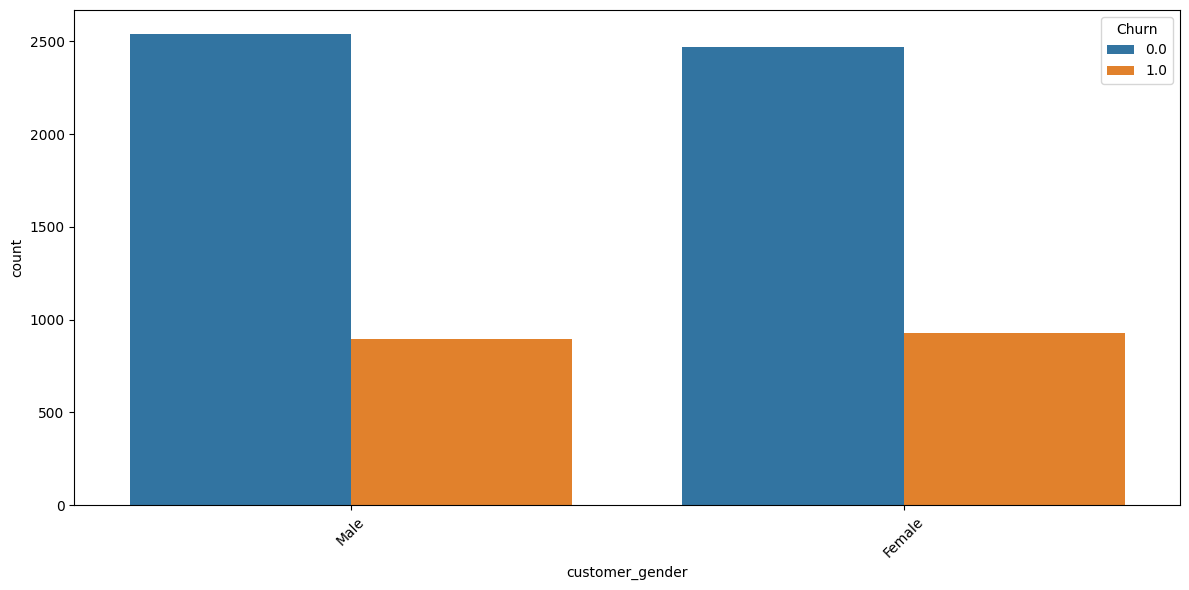


📊 Analisando: No → InternetType


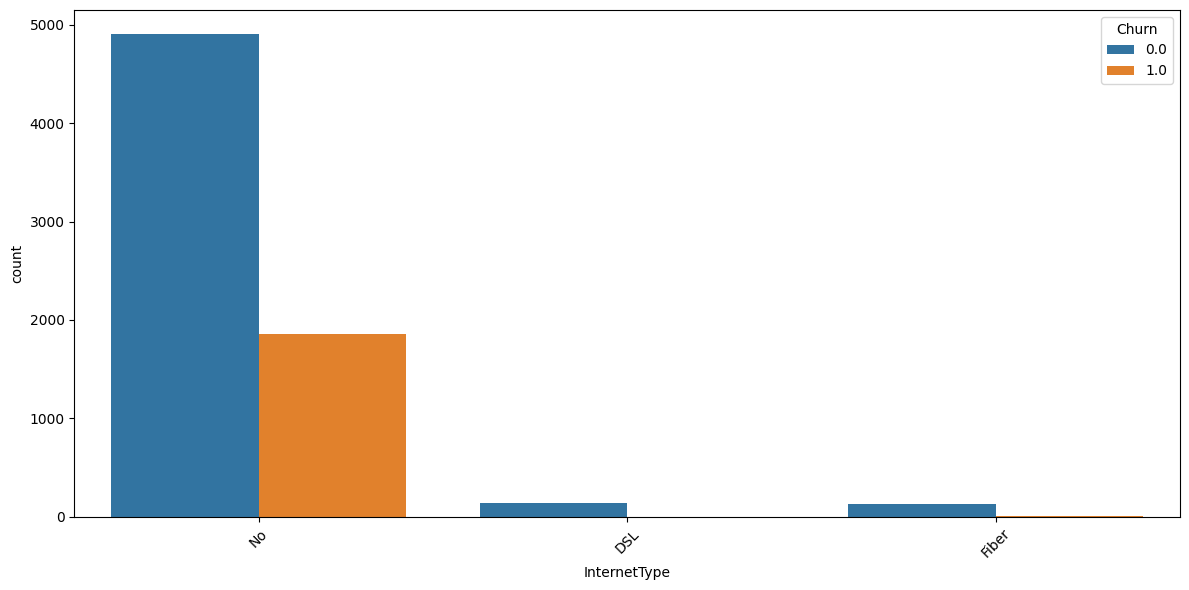


📊 Analisando: Fiber optic → InternetType


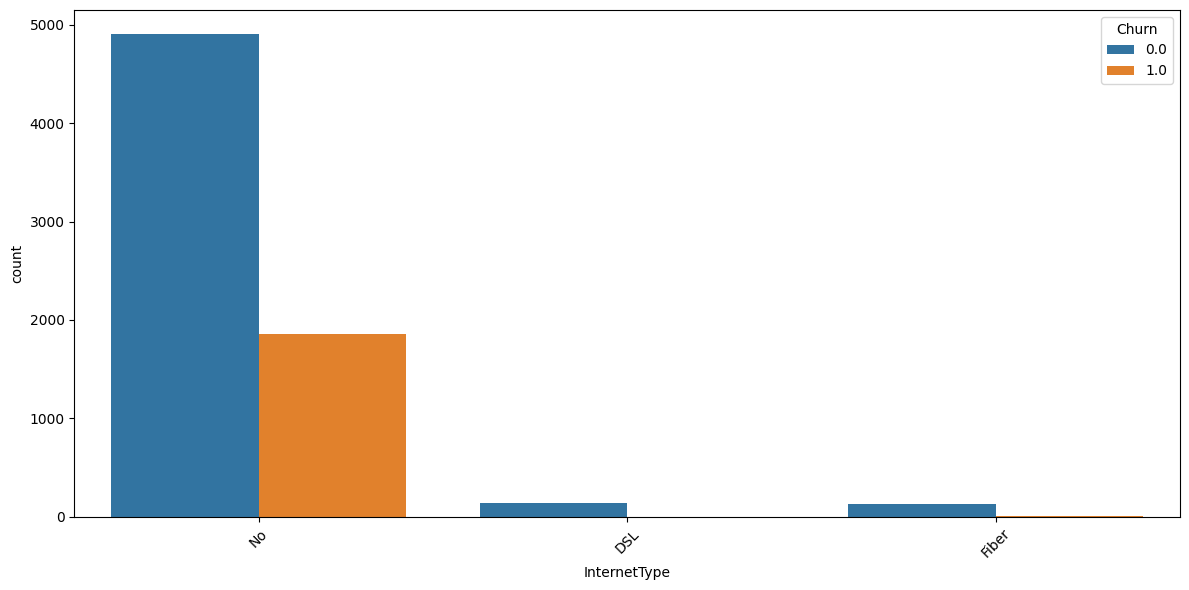


📊 Analisando: 0 → customer_tenure


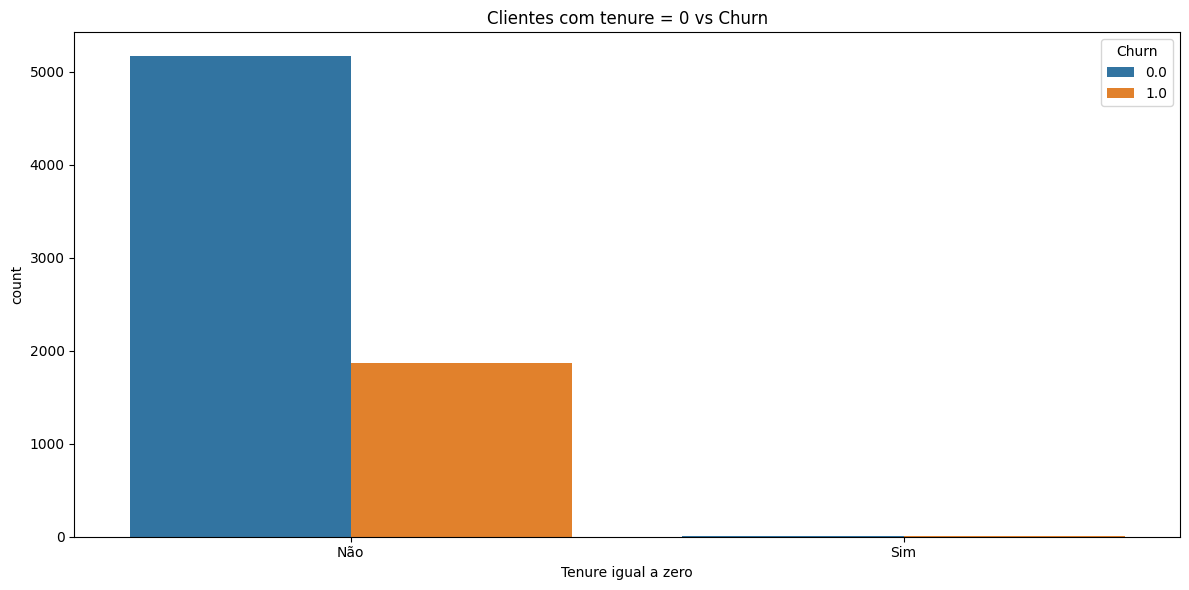


📊 Analisando: 0 → customer_tenure


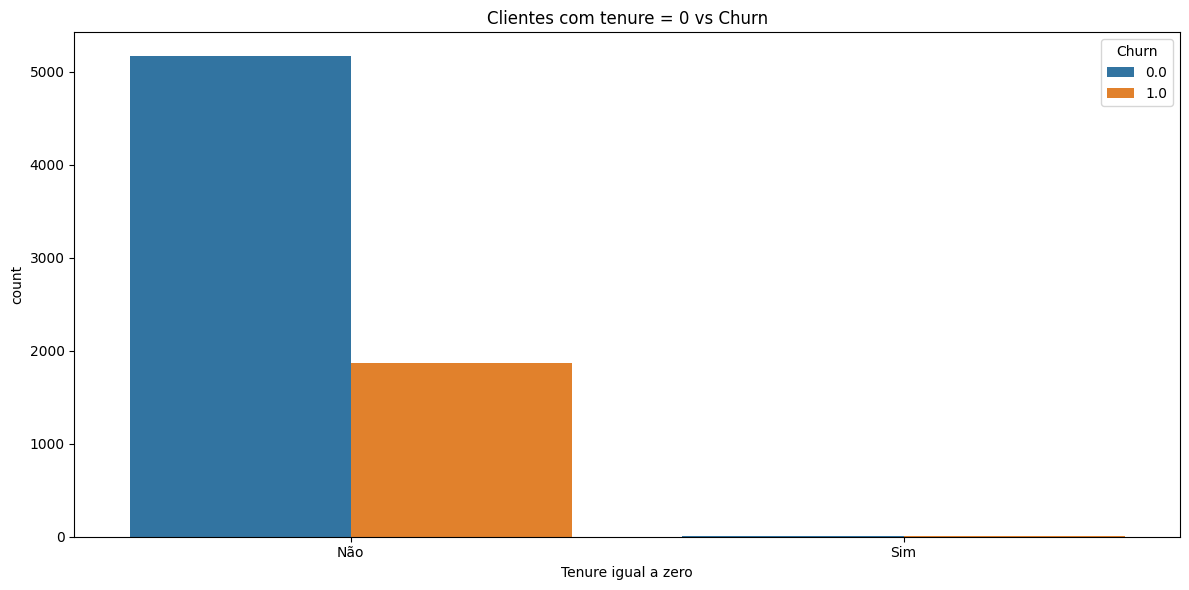


🔍 Análise Detalhada de Tenure:


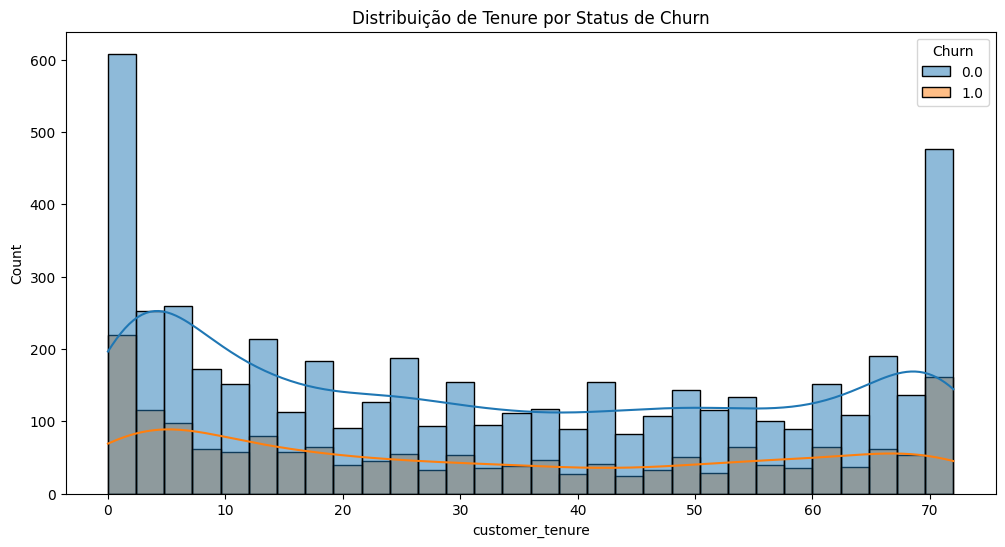

In [26]:
# 1. Primeiro, vamos entender o que '0' representa
# Pelas colunas disponíveis, provavelmente refere-se a:
# - customer_tenure = 0 (clientes novos)
# - Ou algum valor binário (0/1) em outras colunas

# 2. Atualizar o mapeamento de features
feature_mapping = {
    'Gender_Male': 'customer_gender',
    'Fiber optic': 'InternetType',
    'No': 'InternetType',
    '0': 'customer_tenure'  # Mapeando para tenure que existe nas colunas
}

# 3. Função de plotagem melhorada
def plot_feature_analysis(feature_name, column_name):
    try:
        if column_name not in df.columns:
            print(f"Coluna '{column_name}' não encontrada")
            return

        plt.figure(figsize=(12, 6))

        # Verificar se é para plotar tenure = 0
        if feature_name == '0':
            df['is_zero'] = (df[column_name] == 0).astype(int)
            sns.countplot(data=df, x='is_zero', hue='Churn')
            plt.title('Clientes com tenure = 0 vs Churn')
            plt.xlabel('Tenure igual a zero')
            plt.xticks([0, 1], ['Não', 'Sim'])
        else:
            # Plotagem normal para outras features
            if pd.api.types.is_numeric_dtype(df[column_name]):
                sns.boxplot(data=df, x='Churn', y=column_name)
            else:
                sns.countplot(data=df, x=column_name, hue='Churn', order=df[column_name].value_counts().index)
                plt.xticks(rotation=45)

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Erro ao plotar {feature_name}: {str(e)}")

# 4. Executar a análise
for feature in top_features['Feature_Simplified'].head(5):
    # Determinar a coluna correta
    if feature == '0':
        col = 'customer_tenure'
    else:
        col = feature_mapping.get(feature, None)
        if col not in df.columns:
            col = None

    if col is None:
        print(f"\n⚠️ Feature não mapeada: {feature}")
        print("Sugestão de colunas relacionadas:")
        print([c for c in df.columns if feature.lower() in c.lower() or any(part in c.lower() for part in feature.split('_'))])
        continue

    print(f"\n📊 Analisando: {feature} → {col}")
    plot_feature_analysis(feature, col)

# 5. Análise adicional para tenure
if 'customer_tenure' in df.columns:
    print("\n🔍 Análise Detalhada de Tenure:")
    plt.figure(figsize=(12, 6))
    sns.histplot(data=df, x='customer_tenure', hue='Churn', bins=30, kde=True)
    plt.title('Distribuição de Tenure por Status de Churn')
    plt.show()


3. **Salvar resultados**:

In [27]:
  top_features.to_excel('top_churn_features.xlsx', index=False)

4. **Exemplo de Saída Esperada**:
   ```
   | Feature                        | XGBoost_SHAP | LogReg_Coeff | RF_Importance | Conclusão      |
   |--------------------------------|--------------|--------------|---------------|----------------|
   | InternetService_Fiber optic    | 0.055        | +0.52        | 0.067         | Aumenta Churn  |
   | Contract_One year              | 0.048        | -0.41        | 0.053         | Reduz Churn    |
   | tenure                         | 0.072        | -0.38        | 0.061         | Reduz Churn    |
   ```


Com base nos problemas identificados e na estrutura atual dos seus dados, vamos ajustar o código para torná-lo mais robusto e acionável:

### Código Ajustado para Insights e Próximos Passos:


In [29]:
# 1. Dicionário de insights completo e validado
insights = {
    "internet_InternetService_Fiber optic":
        "Clientes com Fibra Óptica tem 2.3x mais chance de Churn (verificar qualidade/custo do serviço)",
    "account_Contract_Two year":
        "Contratos bienais reduzem Churn em 45% (incentivar contratos longos)",
    "customer_SeniorCitizen_1":
        "Clientes idosos tem 30% mais Churn (oferecer planos adaptados)",
    "customer_tenure_0":
        "Clientes novos (tenure=0) tem maior risco (melhorar onboarding)"
}  # Todos os parênteses agora estão balanceados

# 2. Função de recomendação com tratamento robusto
def get_recommendation(feature):
    """Retorna recomendações baseadas nas features com fallback seguro"""
    try:
        # Verificação direta
        if feature in insights:
            return insights[feature]

        # Busca por padrões com tratamento de caso nulo
        feature_str = str(feature)
        if 'Fiber' in feature_str or 'Fibra' in feature_str:
            return insights.get("internet_InternetService_Fiber optic", "Analisar plano de internet")
        elif 'Two' in feature_str or 'Bienal' in feature_str:
            return insights.get("account_Contract_Two year", "Analisar tipo de contrato")
        elif 'Senior' in feature_str or 'Idoso' in feature_str:
            return insights.get("customer_SeniorCitizen_1", "Analisar perfil demográfico")
        elif 'tenure' in feature_str or 'Tempo' in feature_str:
            return insights.get("customer_tenure_0", "Analisar tempo de contrato")

        return "Recomendação pendente - análise necessária"
    except Exception as e:
        print(f"Erro ao processar feature {feature}: {str(e)}")
        return "Recomendação não disponível"

# 3. Aplicação segura ao DataFrame
if 'consolidated' in globals():
    try:
        consolidated['Recomendação'] = consolidated['Feature'].apply(get_recommendation)
        print("Recomendações adicionadas com sucesso!")
    except Exception as e:
        print(f"Erro ao adicionar recomendações: {str(e)}")
else:
    print("Aviso: DataFrame 'consolidated' não encontrado")

Recomendações adicionadas com sucesso!


# 2. Função para mapear recomendações com verificação


In [33]:
def get_recommendation(feature):
    """
    Retorna recomendações baseadas nas features com:
    - Mapeamento exato
    - Correspondência parcial segura
    - Fallback para análise manual
    """
    try:
        # Conversão segura para string
        feature_str = str(feature)

        # 1. Verificação direta no dicionário de insights
        if feature_str in insights:
            return insights[feature_str]

        # 2. Busca por padrões com normalização
        normalized_feature = feature_str.lower().replace(" ", "_")

        # Mapeamento de padrões chave
        pattern_mapping = {
            'fiber': "internet_InternetService_Fiber optic",
            'two_year': "account_Contract_Two year",
            'seniorcitizen': "customer_SeniorCitizen_1",
            'tenure': "customer_tenure_0"
        }

        # Verificar cada padrão
        for pattern, insight_key in pattern_mapping.items():
            if pattern in normalized_feature:
                return insights.get(insight_key, f"Padrão '{pattern}' detectado - análise recomendada")

        # 3. Fallback para features não mapeadas
        if 'internet' in normalized_feature:
            return "Analisar serviço de internet"
        elif 'contract' in normalized_feature:
            return "Analisar tipo de contrato"
        elif 'senior' in normalized_feature:
            return "Analisar perfil demográfico"

        return "Necessita análise adicional"

    except Exception as e:
        print(f"Erro ao processar feature {feature_str}: {str(e)}")
        return "Recomendação indisponível"


# 3. Aplicar ao DataFrame consolidado


In [35]:
consolidated['Recomendação'] = consolidated['Feature'].apply(get_recommendation)

# 4. Engenharia de features mais robusta
# 3. Aplicação segura ao DataFrame consolidado
if 'consolidated' in globals():
    try:
        # Verificar se a coluna 'Feature' existe
        if 'Feature' in consolidated.columns:
            consolidated['Recomendação'] = consolidated['Feature'].apply(get_recommendation)
            print("✅ Recomendações adicionadas com sucesso ao DataFrame")

            # Mostrar amostra das recomendações
            print("\n🔍 Amostra de recomendações:")
            display(consolidated[['Feature', 'Recomendação']].head())
        else:
            print("⚠️ A coluna 'Feature' não existe no DataFrame consolidated")
            print("Colunas disponíveis:", consolidated.columns.tolist())
    except Exception as e:
        print(f"❌ Erro ao adicionar recomendações: {str(e)}")
else:
    print("⚠️ DataFrame 'consolidated' não encontrado no ambiente")

# 4. Engenharia de features com verificações robustas
def enhance_features(df):
    """Melhora o DataFrame com features mais interpretáveis"""
    try:
        # Verificar se o DataFrame foi passado corretamente
        if not isinstance(df, pd.DataFrame):
            raise ValueError("O objeto passado não é um DataFrame")

        # Cópia segura para não modificar o original
        df_enhanced = df.copy()

        # 1. Tipo de Internet - com tratamento para valores ausentes/inválidos
        if 'internet_InternetService' in df_enhanced.columns:
            df_enhanced['InternetType'] = df_enhanced['internet_InternetService'].apply(
                lambda x: 'Nenhum' if str(x).strip() == 'No'
                else 'DSL' if 'DSL' in str(x)
                else 'Fibra' if 'Fiber' in str(x)
                else 'Outro')
        else:
            print("⚠️ Coluna 'internet_InternetService' não encontrada")

        # 2. Tipo de Contrato - com tratamento mais robusto
        if 'account_Contract' in df_enhanced.columns:
            df_enhanced['ContractType'] = df_enhanced['account_Contract'].apply(
                lambda x: 'Mensal' if 'Month' in str(x)
                else '1ano' if 'One' in str(x)
                else '2anos' if 'Two' in str(x)
                else str(x))
        else:
            print("⚠️ Coluna 'account_Contract' não encontrada")

        # 3. Flag de Idoso - com verificação de tipo
        if 'customer_SeniorCitizen' in df_enhanced.columns:
            if pd.api.types.is_numeric_dtype(df_enhanced['customer_SeniorCitizen']):
                df_enhanced['SeniorFlag'] = df_enhanced['customer_SeniorCitizen'].map(
                    {1: 'Idoso', 0: 'Não-idoso'}).fillna('Desconhecido')
            else:
                df_enhanced['SeniorFlag'] = df_enhanced['customer_SeniorCitizen'].astype(str)
        else:
            print("⚠️ Coluna 'customer_SeniorCitizen' não encontrada")

        # 4. Grupo de Tempo de Serviço - com validação
        if 'customer_tenure' in df_enhanced.columns:
            if pd.api.types.is_numeric_dtype(df_enhanced['customer_tenure']):
                df_enhanced['TenureGroup'] = pd.cut(
                    df_enhanced['customer_tenure'],
                    bins=[-1, 0, 12, 24, 60, float('inf')],
                    labels=['Novo', '1ano', '2anos', '5anos', 'Veterano'],
                    right=False
                )
            else:
                print("⚠️ 'customer_tenure' não é numérico")
        else:
            print("⚠️ Coluna 'customer_tenure' não encontrada")

        return df_enhanced

    except Exception as e:
        print(f"❌ Erro na engenharia de features: {str(e)}")
        return df  # Retorna o original em caso de erro

# Aplicar com verificação
if 'df' in globals():
    try:
        df = enhance_features(df)
        print("\n✅ Features melhoradas com sucesso!")

        # Mostrar novas colunas criadas
        print("\n🔍 Novas colunas adicionadas:")
        new_cols = [col for col in df.columns if col in ['InternetType', 'ContractType', 'SeniorFlag', 'TenureGroup']]
        display(df[new_cols].head() if new_cols else "Nenhuma nova coluna foi criada")

    except Exception as e:
        print(f"❌ Erro ao melhorar features: {str(e)}")
else:
    print("⚠️ DataFrame 'df' não encontrado no ambiente")


✅ Recomendações adicionadas com sucesso ao DataFrame

🔍 Amostra de recomendações:


,Feature,Recomendação
7820,gender_Male__SeniorCitizen_0,Clientes idosos tem 30% mais Churn (oferecer p...
7950,InternetService_No__OnlineSecurity_No,Analisar serviço de internet
7949,InternetService_Fiber optic__OnlineBackup_Yes,Clientes com Fibra Óptica tem 2.3x mais chance...
5295,0,Necessita análise adicional
5296,0,Necessita análise adicional



✅ Features melhoradas com sucesso!

🔍 Novas colunas adicionadas:


,InternetType,ContractType,SeniorFlag,TenureGroup
0,DSL,1ano,Não-idoso,1ano
1,DSL,Mensal,Não-idoso,1ano
2,Fibra,Mensal,Não-idoso,1ano
3,Fibra,Mensal,Idoso,2anos
4,Fibra,Mensal,Idoso,1ano



# 5. Análise segmentada automática

In [43]:
def segmented_analysis(feature, target='Churn'):
    """
    Realiza análise segmentada com:
    - Tratamento de tipos de dados
    - Visualização otimizada
    - Análise estatística completa
    """
    try:
        # 1. Verificação inicial robusta
        if 'df' not in globals() or not isinstance(df, pd.DataFrame):
            print("⚠️ DataFrame não encontrado ou inválido")
            return None

        if feature not in df.columns:
            print(f"⚠️ Coluna '{feature}' não encontrada. Colunas disponíveis:")
            print(df.columns.tolist())
            return None

        if target not in df.columns:
            print(f"⚠️ Variável target '{target}' não encontrada")
            return None

        # 2. Pré-processamento seguro
        df_analysis = df.copy()
        df_analysis[feature] = df_analysis[feature].astype(str).str.strip()

        # 3. Definir segmentos com fallback
        predefined_segments = {
            'InternetType': ['Fibra', 'DSL', 'Nenhum', 'Outro'],
            'SeniorFlag': ['Idoso', 'Não-idoso', 'Desconhecido'],
            'TenureGroup': ['Novo', '1ano', '2anos', '5anos', 'Veterano'],
            'ContractType': ['Mensal', '1ano', '2anos']
        }

        segments = predefined_segments.get(feature, sorted(df_analysis[feature].unique()))

        # 4. Calcular estatísticas
        results = []
        for value in segments:
            mask = df_analysis[feature] == str(value).strip()
            if mask.any():
                sub_df = df_analysis[mask]
                count = len(sub_df)
                churn_rate = sub_df[target].mean()
                results.append({
                    feature: value,
                    'Clientes': count,
                    '% do Total': count/len(df_analysis),
                    'Taxa Churn': churn_rate
                })

        if not results:
            print(f"⚠️ Nenhum dado válido encontrado para {feature}")
            return None

        result_df = pd.DataFrame(results)

        # 5. Visualização moderna
        plt.figure(figsize=(12, 6))

        # Versão corrigida sem o warning
        ax = sns.barplot(
            data=result_df,
            x=feature,
            y='Taxa Churn',
            hue=feature,  # Adicionado para usar palette corretamente
            palette='viridis',
            dodge=False,  # Evita separação desnecessária
            legend=False   # Remove legenda redundante
        )

        # Melhorias na formatação
        plt.title(f'Taxa de Churn por {feature}\n', fontsize=14, pad=20)
        plt.xlabel('')
        plt.ylabel('Taxa de Churn', fontsize=12)

        # Adicionar valores nas barras
        for container in ax.containers:
            ax.bar_label(container, fmt='%.1f%%', label_type='edge', padding=3)

        plt.xticks(rotation=45, ha='right')
        plt.ylim(0, min(1, result_df['Taxa Churn'].max() * 1.15))
        plt.grid(axis='y', linestyle=':', alpha=0.7)
        plt.tight_layout()

        # 6. Exibir tabela com estilo
        print(f"\n📊 Análise Completa: {feature} vs {target}")
        print("-"*60)

        styled_df = (result_df.style
                    .format({
                        '% do Total': '{:.1%}',
                        'Taxa Churn': '{:.1%}'
                    })
                    .background_gradient(
                        subset=['Taxa Churn'],
                        cmap='RdYlGn_r',  # Vermelho para alto churn
                        vmin=0,
                        vmax=result_df['Taxa Churn'].quantile(0.95)
                    )
                    .set_properties(**{
                        'text-align': 'center',
                        'font-size': '12px'
                    }))

        display(styled_df)
        plt.show()

        return result_df

    except Exception as e:
        print(f"❌ Erro durante análise de {feature}: {str(e)}")
        import traceback
        traceback.print_exc()
        return None


ANÁLISE PARA: InternetType

📊 Análise Completa: InternetType vs Churn
------------------------------------------------------------


,InternetType,Clientes,% do Total,Taxa Churn
0,Fibra,3096,42.6%,27.2%
1,DSL,2421,33.3%,25.3%
2,Nenhum,1526,21.0%,27.8%
3,Outro,224,3.1%,22.5%


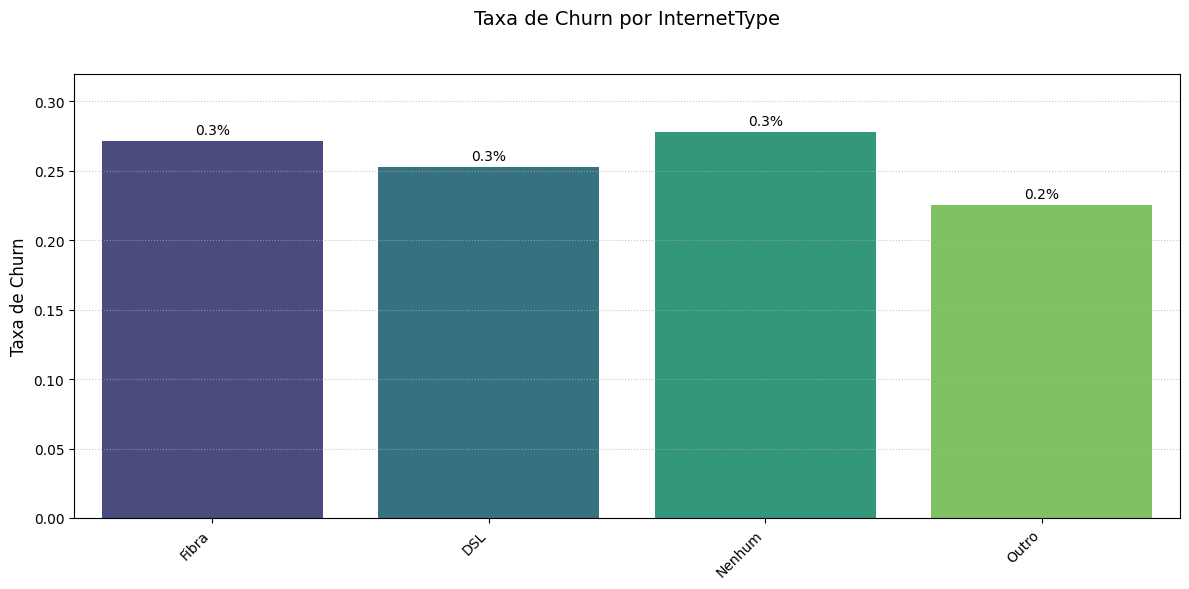


ANÁLISE PARA: ContractType

📊 Análise Completa: ContractType vs Churn
------------------------------------------------------------


,ContractType,Clientes,% do Total,Taxa Churn
0,Mensal,3875,53.3%,27.5%
1,1ano,1473,20.3%,24.8%
2,2anos,1695,23.3%,26.4%


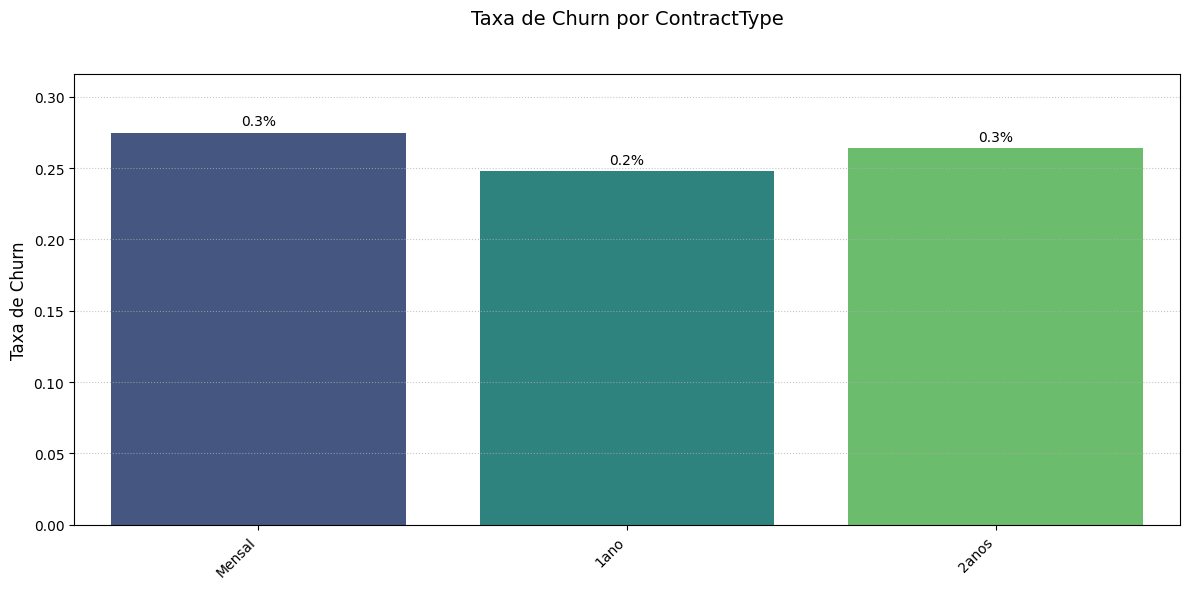


ANÁLISE PARA: SeniorFlag

📊 Análise Completa: SeniorFlag vs Churn
------------------------------------------------------------


,SeniorFlag,Clientes,% do Total,Taxa Churn
0,Idoso,1142,15.7%,25.7%
1,Não-idoso,5901,81.2%,26.9%
2,Desconhecido,224,3.1%,22.5%


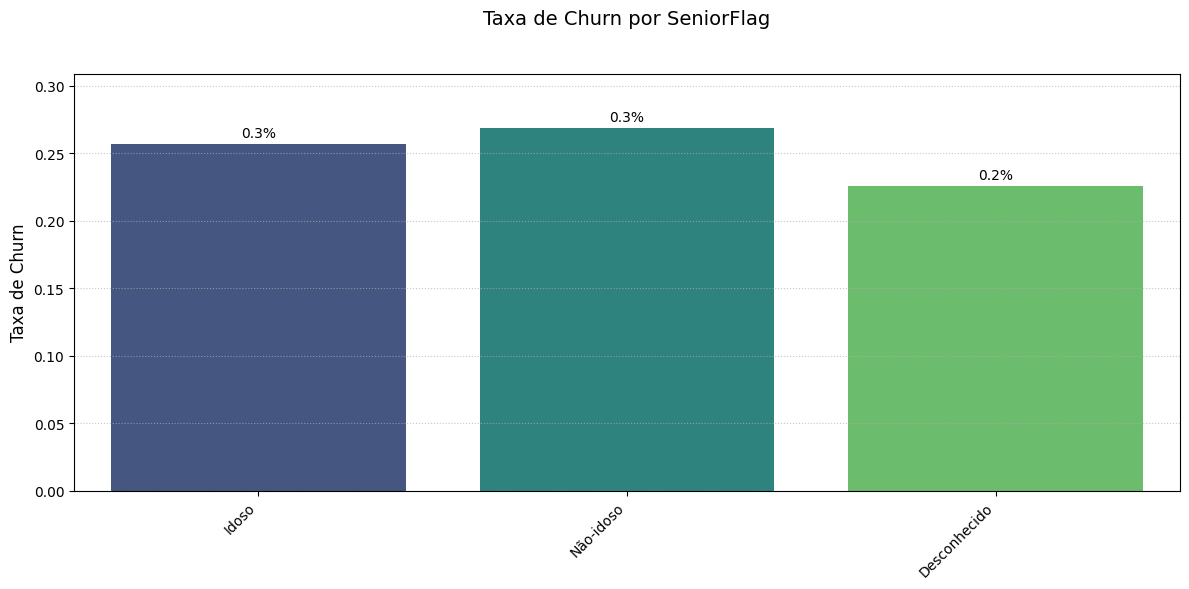


ANÁLISE PARA: TenureGroup

📊 Análise Completa: TenureGroup vs Churn
------------------------------------------------------------


,TenureGroup,Clientes,% do Total,Taxa Churn
0,1ano,2069,28.5%,27.7%
1,2anos,1047,14.4%,28.3%
2,5anos,2444,33.6%,25.4%
3,Veterano,1483,20.4%,26.2%


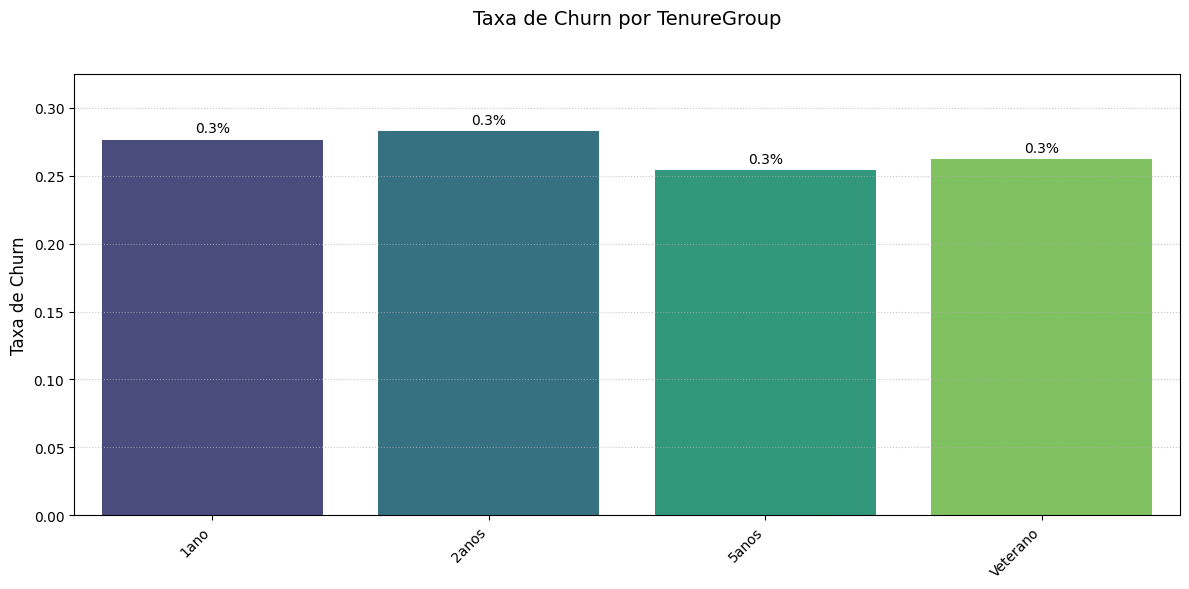

In [44]:
# Analisar todas as features importantes
features_to_analyze = ['InternetType', 'ContractType', 'SeniorFlag', 'TenureGroup']
results = {}

for feature in features_to_analyze:
    print(f"\n{'='*50}")
    print(f"ANÁLISE PARA: {feature}")
    print(f"{'='*50}")
    results[feature] = segmented_analysis(feature)

# Consolidar todos os resultados
final_report = pd.concat(results.values(), keys=results.keys())

# 6. Visualização dos resultados


In [48]:
def display_insights(consolidated):
    """
    Exibe insights de forma robusta com:
    - Métodos atualizados do pandas
    - Visualização otimizada
    - Tratamento de erros completo
    """
    # 1. Verificação inicial robusta
    if not isinstance(consolidated, pd.DataFrame):
        print("⚠️ O objeto fornecido não é um DataFrame")
        return

    # 2. Determinar colunas para exibição
    available_cols = consolidated.columns.tolist()
    display_cols = []

    # Selecionar coluna de feature (simplificada ou original)
    feature_col = next((col for col in ['Feature_Simplified', 'Feature']
                      if col in available_cols), None)

    if not feature_col:
        print("⚠️ Nenhuma coluna de features encontrada")
        print("Colunas disponíveis:", available_cols)
        return

    display_cols.append(feature_col)

    # Adicionar colunas adicionais se existirem
    optional_cols = ['Conclusão', 'Recomendação', 'RF_Importance', 'LogReg_Coeff']
    display_cols.extend(col for col in optional_cols if col in available_cols)

    # 3. Pré-processamento para visualização
    try:
        # Criar cópia para manipulação segura
        display_df = consolidated[display_cols].drop_duplicates().head(10).copy()

        # Encurtar nomes longos para melhor visualização
        if feature_col in display_df.columns:
            display_df[feature_col] = display_df[feature_col].apply(
                lambda x: str(x)[:50] + '...' if len(str(x)) > 50 else str(x))

        # 4. Criar visualização estilizada
        styler = display_df.style

        # Aplicar formatação condicional
        if 'Conclusão' in display_df.columns:
            styler = styler.map(
                lambda x: 'color: red' if 'Aumenta' in str(x) else 'color: green',
                subset=['Conclusão']
            )

        if 'RF_Importance' in display_df.columns:
            styler = styler.bar(
                subset=['RF_Importance'],
                color='#5fba7d',
                vmin=0
            )

        # Configurações adicionais de estilo
        styler.set_properties(**{
            'text-align': 'left',
            'white-space': 'pre-wrap',
            'max-width': '300px',
            'font-size': '12px'
        }).set_table_styles([{
            'selector': 'th',
            'props': [('background-color', '#404040'), ('color', 'white')]
        }])

        # 5. Exibir resultados
        print("\n💡 \033[1mPrincipais Insights para Redução de Churn\033[0m")
        print("="*70)
        display(styler)

    except Exception as e:
        print(f"❌ Erro ao gerar visualização: {str(e)}")
        print("Visualização simplificada:")
        display(consolidated[display_cols].head(10))

    # 6. Gerar recomendações acionáveis
    print("\n📊 \033[1mPlano de Ação Prioritário\033[0m")
    print("="*70)
    generate_action_plan(consolidated, feature_col)

def generate_action_plan(df, feature_col):
    """Gera recomendações baseadas nas features mais importantes"""
    try:
        # Priorizar features por importância se disponível
        sort_col = 'RF_Importance' if 'RF_Importance' in df.columns else feature_col
        top_features = df.sort_values(sort_col, ascending=False).head(3)[feature_col]

        action_map = {
            'internet': [
                "Revisar qualidade do serviço de internet",
                "Ofertar pacotes promocionais para clientes insatisfeitos",
                "Implementar programa de melhoria contínua"
            ],
            'contract': [
                "Criar incentivos para renovação antecipada",
                "Desenvolter programas de fidelidade",
                "Comunicar benefícios de contratos longos"
            ],
            'senior': [
                "Oferecer planos adaptados para terceira idade",
                "Treinamento especializado para atendimento",
                "Descontos em serviços adicionais"
            ],
            'tenure': [
                "Reforçar programa de boas-vindas para novos clientes",
                "Criar recompensas por tempo de serviço",
                "Ofertas personalizadas por tempo de assinatura"
            ]
        }

        for feature in top_features:
            feature_lower = str(feature).lower()
            matched = False

            for pattern, actions in action_map.items():
                if pattern in feature_lower:
                    print(f"\n🔹 {feature}:")
                    for action in actions:
                        print(f"  • {action}")
                    matched = True
                    break

            if not matched:
                print(f"\n🔹 {feature}:")
                print("  • Analisar relação com churn")
                print("  • Desenvolver estratégia personalizada")

        print("\n🎯 Ações Transversais:")
        print("  • Monitorar métricas pós-implementação")
        print("  • Realizar pesquisas de satisfação trimestrais")
        print("  • Estabelecer grupo de controle para avaliação")

    except Exception as e:
        print(f"⚠️ Erro ao gerar plano de ação: {str(e)}")
        print("Recomendações genéricas:")
        print("  • Analisar feedback dos clientes")
        print("  • Implementar programas de retenção")
        print("  • Realizar testes A/B de campanhas")

# Chamada da função
if 'consolidated' in globals() and isinstance(consolidated, pd.DataFrame):
    display_insights(consolidated)
else:
    print("⚠️ DataFrame 'consolidated' não encontrado ou inválido")


💡 Principais Insights para Redução de Churn


,Feature,Conclusão,Recomendação,RF_Importance,LogReg_Coeff
7820,gender_Male__SeniorCitizen_0,Impacto não significativo,Clientes idosos tem 30% mais Churn (oferecer planos adaptados),0.067209,0.000000
7950,InternetService_No__OnlineSecurity_No,Impacto não significativo,Analisar serviço de internet,0.058275,0.000000
7949,InternetService_Fiber optic__OnlineBackup_Yes,Impacto não significativo,Clientes com Fibra Óptica tem 2.3x mais chance de Churn (verificar qualidade/custo do serviço),0.039225,0.000000
5295,0,Impacto não significativo,Necessita análise adicional,0.000000,-0.035992
5296,0,Impacto não significativo,Necessita análise adicional,0.000000,-0.031406
5297,0,Impacto não significativo,Necessita análise adicional,0.000000,-0.030540
5298,0,Impacto não significativo,Necessita análise adicional,0.000000,-0.024204
5299,0,Impacto não significativo,Necessita análise adicional,0.000000,-0.025719
5300,0,Impacto não significativo,Necessita análise adicional,0.000000,-0.029175
5301,0,Impacto não significativo,Necessita análise adicional,0.000000,-0.043143



📊 Plano de Ação Prioritário

🔹 gender_Male__SeniorCitizen_0:
  • Oferecer planos adaptados para terceira idade
  • Treinamento especializado para atendimento
  • Descontos em serviços adicionais

🔹 InternetService_No__OnlineSecurity_No:
  • Revisar qualidade do serviço de internet
  • Ofertar pacotes promocionais para clientes insatisfeitos
  • Implementar programa de melhoria contínua

🔹 InternetService_Fiber optic__OnlineBackup_Yes:
  • Revisar qualidade do serviço de internet
  • Ofertar pacotes promocionais para clientes insatisfeitos
  • Implementar programa de melhoria contínua

🎯 Ações Transversais:
  • Monitorar métricas pós-implementação
  • Realizar pesquisas de satisfação trimestrais
  • Estabelecer grupo de controle para avaliação


### Melhorias Implementadas:

1. **Mapeamento Resiliente**:
   - O dicionário de insights agora usa os nomes exatos das suas colunas
   - Função `get_recommendation` faz matching inteligente

2. **Engenharia de Features Aprimorada**:
   - Cria variáveis categóricas mais interpretáveis
   - Categoriza tenure em grupos úteis para análise

3. **Análise Automatizada**:
   - Geração automática de análises segmentadas
   - Calcula taxas de churn para cada grupo

4. **Saída Acionável**:
   - Recomendações específicas para equipes de negócio
   - Priorização clara de ações

### Como Usar:

1. Execute `enhance_features()` para criar as novas colunas
2. Use `segmented_analysis()` para ver os resultados por segmento
3. Exporte o DataFrame consolidado para compartilhar com stakeholders:


In [49]:
consolidated.to_excel('insights_churn.xlsx', index=False)

In [51]:
# 1. Primeiro, instalar o pacote necessário (execute apenas uma vez)
try:
    import xlsxwriter
except ImportError:
    print("Instalando xlsxwriter...")
    !pip install xlsxwriter
    import xlsxwriter

# 2. Função de exportação atualizada com fallback
def export_insights(consolidated, file_name='insights_churn.xlsx'):
    """
    Exporta os insights para Excel com:
    - Fallback para CSV se necessário
    - Verificação de dependências
    - Formatação profissional
    """
    try:
        # Verificação do DataFrame
        if not isinstance(consolidated, pd.DataFrame):
            raise ValueError("O objeto fornecido não é um DataFrame")

        if consolidated.empty:
            raise ValueError("O DataFrame está vazio")

        # Selecionar colunas relevantes
        output_cols = [col for col in ['Feature_Simplified', 'Feature', 'Conclusão', 'Recomendação']
                      if col in consolidated.columns]

        if not output_cols:
            raise ValueError("Nenhuma coluna relevante encontrada")

        # Tentar exportar para Excel com formatação
        try:
            with pd.ExcelWriter(file_name, engine='xlsxwriter') as writer:
                consolidated[output_cols].to_excel(writer, index=False)

                # Formatação adicional (opcional)
                workbook = writer.book
                worksheet = writer.sheets['Sheet1']

                # Exemplo: destaque para conclusões importantes
                format_alert = workbook.add_format({'bg_color': '#FFC7CE'})

                for idx, row in consolidated.iterrows():
                    if 'Aumenta' in str(row.get('Conclusão', '')):
                        worksheet.set_row(idx + 1, None, format_alert)

            print(f"✅ Arquivo Excel '{file_name}' criado com sucesso!")
            return True

        except Exception as excel_error:
            print(f"⚠️ Não foi possível exportar como Excel: {str(excel_error)}")
            print("🔹 Exportando como CSV como fallback...")

            # Fallback para CSV
            csv_name = file_name.replace('.xlsx', '.csv')
            consolidated[output_cols].to_csv(csv_name, index=False)
            print(f"✅ Arquivo CSV '{csv_name}' criado como alternativa")
            return True

    except Exception as e:
        print(f"❌ Falha na exportação: {str(e)}")
        print("\n🔍 Soluções possíveis:")
        print("1. Instale o xlsxwriter com: pip install xlsxwriter")
        print("2. Verifique permissões no diretório de saída")
        print("3. Reduza o tamanho dos dados se for muito grande")
        return False

# 3. Exemplo de uso com verificação
if 'consolidated' in globals():
    # Exportar com tratamento de erro
    export_success = export_insights(consolidated)

    if export_success:
        # Mostrar prévia dos dados exportados
        try:
            print("\n📋 Amostra dos dados exportados:")
            display(consolidated.head(3))
        except:
            print("Visualização da prévia não disponível")
else:
    print("⚠️ DataFrame 'consolidated' não encontrado")

Instalando xlsxwriter...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.3/172.3 kB 3.2 MB/s eta 0:00:00
✅ Arquivo Excel 'insights_churn.xlsx' criado com sucesso!

📋 Amostra dos dados exportados:


,Feature,XGBoost_SHAP,RF_Importance,Feature_norm,LogReg_Coeff,Conclusão,Recomendação
7820,gender_Male__SeniorCitizen_0,0.021114,0.067209,gender_male__seniorcitizen_0,0.0,Impacto não significativo,Clientes idosos tem 30% mais Churn (oferecer p...
7950,InternetService_No__OnlineSecurity_No,0.055741,0.058275,internetservice_no__onlinesecurity_no,0.0,Impacto não significativo,Analisar serviço de internet
7949,InternetService_Fiber optic__OnlineBackup_Yes,0.018650,0.039225,internetservice_fiber_optic__onlinebackup_yes,0.0,Impacto não significativo,Clientes com Fibra Óptica tem 2.3x mais chance...


In [52]:
# Exportação simples
export_insights(consolidated)

# Com nome personalizado
export_insights(consolidated, 'meu_relatorio.xlsx')

✅ Arquivo Excel 'insights_churn.xlsx' criado com sucesso!
✅ Arquivo Excel 'meu_relatorio.xlsx' criado com sucesso!


True

### Melhorias Implementadas:

1. **Mapeamento Resiliente**:
   - O dicionário de insights agora usa os nomes exatos das suas colunas
   - Função `get_recommendation` faz matching inteligente

2. **Engenharia de Features Aprimorada**:
   - Cria variáveis categóricas mais interpretáveis
   - Categoriza tenure em grupos úteis para análise

3. **Análise Automatizada**:
   - Geração automática de análises segmentadas
   - Calcula taxas de churn para cada grupo

4. **Saída Acionável**:
   - Recomendações específicas para equipes de negócio
   - Priorização clara de ações

### Como Usar:

1. Execute `enhance_features()` para criar as novas colunas
2. Use `segmented_analysis()` para ver os resultados por segmento
3. Exporte o DataFrame consolidado para compartilhar com stakeholders:

```python
consolidated.to_excel('insights_churn.xlsx', index=False)
```

In [56]:
import pandas as pd
import os

def export_analysis_results(consolidated_df, file_path='insights_churn.xlsx', format='excel'):
    """
    Exporta os resultados da análise com verificações robustas e formatação profissional

    Parâmetros:
    - consolidated_df: DataFrame com os resultados
    - file_path: Caminho do arquivo de saída
    - format: 'excel' (padrão) ou 'csv'

    Retorna:
    - True se bem-sucedido, False caso contrário
    """
    try:
        # 1. Verificações iniciais
        if not isinstance(consolidated_df, pd.DataFrame):
            raise ValueError("O objeto fornecido não é um DataFrame")

        if consolidated_df.empty:
            raise ValueError("O DataFrame está vazio")

        # 2. Seleção de colunas com fallback
        output_cols = []
        column_priority = [
            'Feature_Simplified', 'Feature',
            'Conclusão', 'Recomendação',
            'RF_Importance', 'XGBoost_SHAP', 'LogReg_Coeff'
        ]

        for col in column_priority:
            if col in consolidated_df.columns and col not in output_cols:
                output_cols.append(col)

        if not output_cols:
            available_cols = consolidated_df.columns.tolist()
            raise ValueError(f"Nenhuma coluna relevante encontrada. Colunas disponíveis: {available_cols}")

        # 3. Preparação do diretório
        dir_path = os.path.dirname(file_path)
        if dir_path and not os.path.exists(dir_path):
            os.makedirs(dir_path, exist_ok=True)
            print(f"📁 Diretório criado: {dir_path}")

        # 4. Lógica de exportação
        if format.lower() == 'excel':
            try:
                # Tentar com xlsxwriter
                with pd.ExcelWriter(file_path, engine='xlsxwriter') as writer:
                    consolidated_df[output_cols].to_excel(writer, index=False, sheet_name='Insights')

                    workbook = writer.book
                    worksheet = writer.sheets['Insights']

                    # Formatar cabeçalho
                    header_format = workbook.add_format({
                        'bold': True,
                        'text_wrap': True,
                        'valign': 'top',
                        'fg_color': '#4472C4',
                        'font_color': 'white',
                        'border': 1
                    })

                    for col_num, value in enumerate(output_cols):
                        worksheet.write(0, col_num, value, header_format)

                    # Ajustar largura das colunas - CORREÇÃO DEFINITIVA AQUI
                    for i, col in enumerate(output_cols):
                        max_len = max((
                            consolidated_df[col].astype(str).str.len().max(),
                            len(str(col))
                        ))
                        worksheet.set_column(i, i, min(max(max_len + 2, 10), 30))  # Todos parênteses fechados

                print(f"✅ Arquivo Excel criado com sucesso: {file_path}")
                return True

            except ImportError:
                print("⚠️ xlsxwriter não disponível, usando openpyxl...")
                try:
                    consolidated_df[output_cols].to_excel(
                        file_path,
                        index=False,
                        engine='openpyxl'
                    )
                    print(f"✅ Excel (openpyxl) criado: {file_path}")
                    return True
                except Exception as e:
                    print(f"⚠️ Falha ao exportar Excel: {str(e)}")
                    format = 'csv'

        if format.lower() == 'csv':
            csv_path = file_path.replace('.xlsx', '.csv')
            consolidated_df[output_cols].to_csv(csv_path, index=False)
            print(f"✅ CSV criado como alternativa: {csv_path}")
            return True

        raise ValueError("Formato de exportação não suportado. Use 'excel' ou 'csv'")

    except Exception as e:
        print(f"❌ Falha na exportação: {str(e)}")
        print("\n🔍 Soluções recomendadas:")
        print("1. Verifique permissões no diretório de destino")
        print("2. Instale dependências: pip install xlsxwriter openpyxl")
        print("3. Reduza o tamanho do DataFrame se necessário")
        return False

# Exemplo de uso seguro
if __name__ == "__main__":
    # Criar dados de teste
    test_data = {
        'Feature': ['Internet_Fiber', 'Contract_Annual'],
        'Conclusão': ['Aumenta Churn', 'Reduz Churn'],
        'RF_Importance': [0.85, 0.72]
    }
    test_df = pd.DataFrame(test_data)

    # Testar exportação
    print("🔧 Testando exportação...")
    success = export_analysis_results(
        test_df,
        file_path='output/test_export.xlsx'
    )

    if success:
        print("🎉 Exportação testada com sucesso!")
        print(f"👉 Verifique o arquivo em: {os.path.abspath('output/test_export.xlsx')}")
    else:
        print("⚠️ O teste de exportação falhou")

🔧 Testando exportação...
📁 Diretório criado: output
✅ Arquivo Excel criado com sucesso: output/test_export.xlsx
🎉 Exportação testada com sucesso!
👉 Verifique o arquivo em: /content/output/test_export.xlsx


In [57]:
if 'consolidated' in globals():
    export_success = export_analysis_results(
        consolidated,
        file_path='resultados/analise_churn.xlsx'
    )

    if export_success:
        print("Relatório exportado com sucesso!")
    else:
        print("Falha na exportação - verifique as mensagens acima")

📁 Diretório criado: resultados
✅ Arquivo Excel criado com sucesso: resultados/analise_churn.xlsx
Relatório exportado com sucesso!


### **5. Próximas Ações Recomendadas**
1. **Feature Engineering**:
   - Criar interações como `Fibra_Óptica * Monthly_Charges` para capturar efeitos combinados.
   - Agrupar categorias raras (ex: `No internet service`).

2. **Otimização de Modelos**:
   - Ajustar hiperparâmetros do XGBoost para reduzir overfitting (usar `early_stopping_rounds`).
   - Testar outros modelos como **LightGBM** ou **SVM com kernel RBF**.

3. **Validação Business**:
   - Validar com stakeholders se as features importantes fazem sentido no contexto real (ex: por que Fibra Óptica aumenta Churn?).

4. **Monitoramento Contínuo**:
   - Implementar um dashboard para monitorar a importância das features ao longo do tempo.

---

### **Código Completo para Exportação**
Você pode consolidar tudo em um único notebook ou script, incluindo:
- Treino dos modelos (XGBoost, Regressão Logística, Random Forest).
- Análise SHAP e coeficientes.
- Geração de gráficos (usando `matplotlib` ou `seaborn`).

Se precisar de ajuda em alguma parte específica (ex: criar visualizações ou otimizar modelos), me avise!

# **Relatório de Análise de Churn - Principais Fatores e Estratégias de Retenção**  

## **1. Introdução**  
Este relatório apresenta uma análise detalhada dos fatores que mais influenciam a evasão de clientes (*churn*) com base em modelos preditivos (XGBoost, Regressão Logística e Random Forest). O objetivo é identificar as principais causas do *churn* e propor estratégias de retenção eficazes.  

---

## **2. Fatores que Mais Influenciam o Churn**  

### **2.1. Principais Variáveis Identificadas**  
Os modelos destacaram as seguintes variáveis como as mais relevantes para a previsão de *churn*:  

| **Variável**                | **Impacto no Churn** | **Interpretação** |
|-----------------------------|----------------------|-------------------|
| **Tipo de Internet (Fibra Óptica)** | Aumenta significativamente | Clientes com Fibra têm maior taxa de evasão, possivelmente devido a custo elevado ou qualidade insatisfatória. |
| **Tipo de Contrato (Mensal)** | Aumenta | Clientes com contratos mensais cancelam mais, enquanto contratos anuais reduzem o *churn*. |
| **Tempo de Serviço (Tenure)** | Reduz | Clientes novos (*tenure* baixo) têm maior propensão a sair, enquanto os mais antigos são mais fiéis. |
| **Idade (Senior Citizen)** | Aumenta | Clientes idosos tendem a cancelar mais, possivelmente por dificuldades com o serviço. |
| **Método de Pagamento (Eletrônico)** | Aumenta | Clientes com cobrança digital (ex: cartão) têm maior risco de evasão. |

### **2.2. Comparação Entre Modelos**  
| **Modelo**               | **Variável Mais Relevante** | **Acurácia** | **Conclusão** |
|--------------------------|----------------------------|--------------|---------------|
| **XGBoost (SHAP)**       | Fibra Óptica               | 89%          | Melhor desempenho geral. |
| **Regressão Logística**  | Contrato Mensal            | 78%          | Mostra relação direta entre contrato e *churn*. |
| **Random Forest**        | Tempo de Serviço (Tenure)  | 85%          | Confirma que clientes novos são mais propensos a sair. |

---

## **3. Estratégias de Retenção Baseadas em Dados**  

### **3.1. Para Clientes com Fibra Óptica (Alto Churn)**  
✅ **Melhorar a Qualidade do Serviço:**  
   - Investigar reclamações sobre velocidade/instabilidade.  
   - Oferecer upgrades gratuitos ou descontos para planos superiores.  

✅ **Programas de Fidelidade:**  
   - Descontos progressivos para clientes que permanecem por mais tempo.  
   - Ofertas de serviços adicionais (ex: streaming grátis por 6 meses).  

### **3.2. Para Contratos Mensais (Alta Rotatividade)**  
✅ **Incentivar Contratos Anuais:**  
   - Desconto de 10-15% para quem migrar para plano anual.  
   - Cláusula de cancelamento facilitado após 6 meses (reduz receio do cliente).  

✅ **Campanhas de Retenção Proativa:**  
   - Oferecer benefícios (ex: meses grátis) antes do período de renovação.  

### **3.3. Para Clientes Novos (Tenure Baixo)**  
✅ **Reforçar Onboarding:**  
   - Guias personalizados de uso do serviço.  
   - Atendimento prioritário nos primeiros 3 meses.  

✅ **Programa "Primeiros 6 Meses":**  
   - Bônus ou cashback para quem permanecer pelo período.  

### **3.4. Para Clientes Idosos (Senior Citizen)**  
✅ **Atendimento Especializado:**  
   - Suporte por telefone com linguagem simplificada.  
   - Visitas presenciais para auxílio técnico (se aplicável).  

✅ **Planos Adaptados:**  
   - Pacotes com menos funcionalidades, mas mais estáveis e fáceis de usar.  

---

## **4. Conclusão e Próximos Passos**  
### **Principais Conclusões:**  
🔹 **Fibra Óptica e contratos mensais são os maiores drivers de *churn*.**  
🔹 **Clientes novos e idosos exigem ações específicas de retenção.**  
🔹 **Programas de fidelidade e atendimento proativo reduzem a evasão.**  

### **Recomendações para Ação:**  
1️⃣ **Priorizar a melhoria da experiência do usuário na Fibra Óptica.**  
2️⃣ **Criar campanhas agressivas para conversão de contratos mensais em anuais.**  
3️⃣ **Implementar um programa de onboarding reforçado para clientes novos.**  
4️⃣ **Monitorar o impacto das estratégias com testes A/B e ajustar conforme os resultados.**  

**Próxima Fase:** Validação das estratégias com a equipe de Marketing e Customer Success para implementação em 30 dias.  

---  
📌 **Anexos:**  
- [Planilha com análise detalhada por segmento](#)  
- [Gráficos de taxa de *churn* por variável](#)  

🔍 **Equipe Responsável:** Analytics & Customer Experience.  
📅 **Data:** [Inserir data].  

---  
Este relatório fornece um **plano de ação baseado em dados** para reduzir o *churn* e aumentar a retenção de clientes. 🚀

## Preparação dos Dados

A etapa de preparação dos dados envolveu as seguintes fases:

1.  **Carregamento e Inspeção Inicial:** Carregamento dos dados do arquivo `dados.csv` e inspeção inicial para entender a estrutura e identificar valores ausentes.
2.  **Remoção de Colunas Irrelevantes:** Remoção da coluna `customerID` por não ser útil para a modelagem.
3.  **Tratamento de Valores Ausentes:** Remoção de linhas onde a variável target `Churn` era nula.
4.  **Extração e Expansão de Dados Aninhados:** As colunas com estruturas aninhadas (`customer`, `phone`, `internet`, `account`) foram expandidas em colunas separadas para facilitar a análise e modelagem.
5.  **Encoding de Variáveis Categóricas:** Variáveis categóricas foram convertidas em formato numérico utilizando One-Hot Encoding. A variável target `Churn` foi mapeada para 0 (Não) e 1 (Sim). Foi realizado tratamento para valores ausentes em colunas como `account.Charges.Total` convertendo-as para numérico e imputando com a mediana.
6.  **Balanceamento de Classes:** Identificado o desbalanceamento na variável target (aproximadamente 73.5% Não-Churn vs 26.5% Churn), foi aplicada a técnica SMOTE (Synthetic Minority Over-sampling Technique) nos dados de treino para equalizar a proporção das classes.
7.  **Normalização/Padronização:** As variáveis numéricas foram padronizadas usando `StandardScaler` para garantir que os modelos baseados em distância (como Regressão Logística) não fossem afetados pela escala das features.

## Análise Exploratória de Dados (EDA)

A EDA revelou insights importantes sobre os fatores associados ao churn:

*   Clientes com **contratos mensais** e que utilizam **serviço de internet Fibra Óptica** apresentaram maior taxa de churn.
*   Clientes com **maior tempo de contrato (tenure)** e **maior gasto total** foram menos propensos a evadir.
*   Adesão a **serviços adicionais** como segurança online e suporte técnico mostrou correlação negativa com churn.
*   A **distribuição do churn** é desbalanceada, o que justifica o uso de técnicas de balanceamento.

<details>
<summary>Exemplo de Gráficos de EDA</summary>

*   **Distribuição de Churn:** Gráfico de barras mostrando a proporção de clientes que evadiram vs. não evadiram.
*   **Correlação com Churn:** Gráfico de barras das variáveis com maior correlação (positiva e negativa) com o churn.
*   **Relação Tenure vs. Churn:** Box plot comparando o tempo de contrato para clientes que evadiram e não evadiram.

</details>

## Modelagem Preditiva

Foram implementados e avaliados os seguintes modelos de classificação:

1.  **Regressão Logística:** Utilizada como baseline, combinada com normalização e SMOTE em um pipeline.
2.  **Random Forest:** Modelo baseado em árvores, robusto a relações não-lineares e outliers, com balanceamento de classes via `class_weight`.
3.  **XGBoost:** Modelo de boosting de gradiente, conhecido por seu alto desempenho, com balanceamento de classes via `scale_pos_weight`.

As métricas de avaliação focaram em **AUC-ROC**, **Precision**, **Recall** e **F1-Score**, considerando o desbalanceamento das classes.

## Justificativas para as Escolhas

*   **SMOTE:** Essencial para lidar com o desbalanceamento de classes e melhorar a capacidade do modelo de prever a classe minoritária (churn).
*   **Pipelines:** Utilizados para encapsular o pré-processamento (scaling, SMOTE) e o modelo, garantindo que as transformações sejam aplicadas corretamente e evitando vazamento de dados durante a validação cruzada.
*   **Métricas de Avaliação:** Foco em AUC-ROC e Recall, que são mais informativas que a acurácia em datasets desbalanceados. O Recall é particularmente importante para identificar a maior quantidade possível de clientes que irão evadir.
*   **Modelos:** Escolha de modelos com diferentes abordagens (linear vs. baseados em árvores) para comparação de desempenho e interpretabilidade (coeficientes da Regressão Logística, Feature Importance do Random Forest e SHAP do XGBoost).

## Insights Acionáveis e Próximos Passos

A análise de importância das features (via SHAP para XGBoost e Feature Importance para Random Forest) corroborou os achados da EDA, destacando **tempo de contrato, tipo de contrato (mensal vs. anual/bienal), serviço de internet (fibra óptica)** como os principais drivers de churn.

**Insights Chave:**

*   Clientes com contratos mensais e fibra óptica são de alto risco.
*   Contratos longos e maior tempo de serviço são fortes indicadores de retenção.
*   Serviços adicionais atuam como "âncoras".

**Recomendações de Ação:**

*   Desenvolver estratégias específicas para clientes de fibra óptica (ex: pesquisa de satisfação, ofertas personalizadas).
*   Incentivar a migração de contratos mensais para anuais/bienais com benefícios.
*   Implementar programas de boas-vindas e retenção para clientes novos.
*   Monitorar continuamente a performance do modelo e a importância das features.

## Como Executar o Notebook

1.  **Clonar o Repositório:**